# Dataset Reduction Techniques to Enable SVD Analysis

In this _Jupyter Notebook_, we examine various methods of performing an SVD. In particular, we will reduce the size of datasets, represented by simulated _Gaussian Random Fields_, and investigate to what degree the output of the reduced dataset differs from the original. These techniques can be useful when the original dataset is very large and performing analyses is computationally costly. The results from the calculations performed here are reported in an ISPRS International Journal of Geo-Information article [3].

## Initialisation

We start by setting up the necessary tools.

### Imports

The following modules are required in this _Jupyter Notebook_.

In [1]:
import gc
import math
import numpy
import scipy
import scipy.linalg
import sklearn.preprocessing
import matplotlib.pyplot
import pysal

## Functions

The following functions will be used throughout this _Jupyter Notebook_. Some are based on standard matrix algebra [6, 7, 8].

### Helper Functions

The _loop_ function runs the function given as the first argument multiple times, until the uncertainty in the mean of the results of that function is below a certain threshold.

In [2]:
def loop(function, args={}, minIterations=5, maxIterations=100, threshold=0.01):
    results = [function(**args) for i in range(minIterations)]
    while numpy.amax(numpy.std(results, axis=0)) / len(results) > threshold and len(results) < maxIterations:
        results.append(function(**args))
    return numpy.mean(results, axis=0)

The _reduceUSV_ function takes the output of an _SVD_ and removes the smallest _singular values_.

In [3]:
def reduceUSV(U, s, Vt, p):
    U = U[:, :p]
    s = s[:p]
    Vt = Vt[:p]
    return U, s, Vt

The _usvToMatrix_ function takes the output of an _SVD_ and reconstructs the original matrix.

In [4]:
def usvToMatrix(U, s, Vt):
    return U @ numpy.diag(s) @ Vt

The _usvToReducedMatrix_ function combines the previous two functions by reconstructing the original matrix, except for the smallest _singular values_.

In [5]:
def usvToReducedMatrix(U, s, Vt, p):
    U, s, Vt = reduceUSV(U, s, Vt, p)
    return usvToMatrix(U, s, Vt)

The _reduceMatrix_ function performs an _SVD_ on the input matrix, reduces its dimensionality and then reconstructs the matrix.

In [6]:
def reduceMatrix(A, p):
    U, s, Vt = scipy.linalg.svd(A, full_matrices = False)
    return usvToReducedMatrix(U, s, Vt, p)

The _standardiseMatrix_ function centers and standardises the input matrix.

In [7]:
def standardiseMatrix(matrix):
    return (matrix - numpy.mean(matrix)) / numpy.std(matrix)

The _centerAndStandardiseField_ function centers and standardises the input matrix by row.

In [8]:
def centerAndStandardiseField(matrix):
    centeredMatrix = matrix - numpy.mean(matrix, axis=1)[:, None]
    standardDeviation = numpy.std(centeredMatrix, axis=1)[:, None]
    standardDeviation[standardDeviation==0] = 1
    return centeredMatrix / standardDeviation

The _centerAndStandardiseSpatioTemporalField_ function centers and standardises the input matrix by the third axis.

In [9]:
def centerAndStandardiseSpatioTemporalField(matrix):
    centeredMatrix = matrix - numpy.mean(matrix, axis=2)[:, :, None]
    standardDeviation = numpy.std(centeredMatrix, axis=2)[:, :, None]
    standardDeviation[standardDeviation==0] = 1
    return centeredMatrix / standardDeviation

The _normaliseShape_ function crops the array such that an integer number of _nrows_ and _ncols_ fits in its rows and columns.

In [10]:
def normaliseShape(array, nrows, ncols):
    h, w = array.shape
    if h % nrows > 0 or w % ncols > 0:
        array = array[:(h//nrows*nrows), :(w//ncols*ncols)]
    return (h//nrows*nrows), (w//ncols*ncols), array

The _flattenSpatialTemporalFields_ function reshapes two 3D matrices into two 2D matrices.

In [11]:
def flattenSpatialTemporalFields(matrix1, matrix2):
    h, w, d = matrix1.shape
    result1 = matrix1.reshape(h * w, d)
    h, w, d = matrix2.shape
    result2 = matrix2.reshape(h * w, d)
    return result1, result2

The _splitSpatialTemporalField_ function splits a 3D matrix into two 3D matrices by taking alternating slices in the third dimension, which is time.

In [12]:
def splitSpatialTemporalField(matrixCombined):
    h, w, d = matrixCombined.shape
    d1 = numpy.arange(0, d, 2)
    d2 = numpy.arange(1, d, 2)
    matrix1 = matrixCombined[:, :, d1]
    matrix2 = matrixCombined[:, :, d2]
    return matrix1, matrix2

The _splitAndFlattenSpatialTemporalField_ function combines the previous two functions.

In [13]:
def splitAndFlattenSpatialTemporalField(matrixCombined):
    matrix1, matrix2 = splitSpatialTemporalField(matrixCombined)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrix1, matrix2)
    return matrixFlattened1, matrixFlattened2

The _addRectangle_ function adds a rectangle to a plot with some text in the middle.

In [14]:
def addRectangle(axis, left, width, height, text, type=None):
    right = left + width
    patch = matplotlib.patches.Rectangle(
        (left, 1-height), width, height,
        fill=False, clip_on=False
        )
    axis.add_patch(patch)
    axis.text(0.5*(left+right), 1-0.5*height, text,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=14)
    left = right + 0.1
    return axis, left

The _addSymbol_ function adds a symbol, or string of text, to a plot.

In [15]:
def addSymbol(axis, left, symbol, width=0.3, left2=0.1, type=None):
    axis.text(left + left2,
              0.85, symbol,
              horizontalalignment='center',
              verticalalignment='center',
              fontsize=14)
    left = left + width
    return axis, left

The _plotMatrixMultiplication_ function takes as input a description of some matrix multiplication and combines the previous two function to make a plot of the mathematics.

In [16]:
def plotMatrixMultiplication(matrixDescription=[{}], filePath=None):
    figure, axis = matplotlib.pyplot.subplots()
    matplotlib.pyplot.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
    matplotlib.pyplot.axis('off')
    figure.set_size_inches(1.5, 1.5)
    left = 0
    for args in matrixDescription:
        if args["type"] is "Matrix":
            axis, left = addRectangle(axis, left, **args)
        elif args["type"] is "Symbol":
            axis, left = addSymbol(axis, left, **args)
    if filePath is not None:
        matplotlib.pyplot.savefig(filePath, bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

The _addBox_ function adds a rectangle with some text to a flow diagram.

In [17]:
def addBox(axis, left=0, bottom=0, text=""):
    patch = matplotlib.patches.Rectangle((left, bottom), 1.8, 0.5, fill=False, clip_on=False)
    axis.add_patch(patch)
    axis.text(left + .9, bottom + .25, text, horizontalalignment='center', verticalalignment='center', fontsize=12)
    return axis

## Introduction

As described in more detail in the accompanying article [3], the method most suitable for reduced SVD's depends on the type of dataset. The flow diagram below suggests what technique is likely to be successful. In this _Jupyter Notebook_, we will examine all these techniques by simulating _Gaussian Random Fields_.

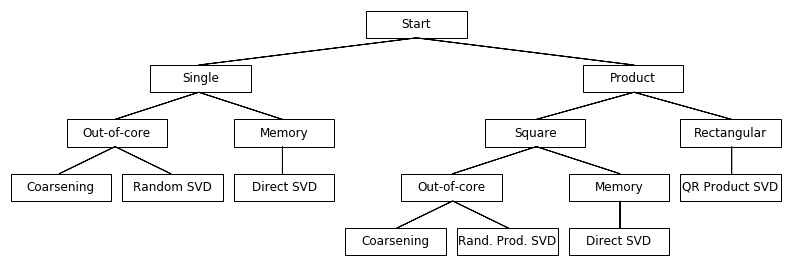

In [18]:
figure, axis = matplotlib.pyplot.subplots()
matplotlib.pyplot.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
matplotlib.pyplot.axis('off')
figure.set_size_inches(13.8, 4.5)
matplotlib.pyplot.xlim([0,13.8])
matplotlib.pyplot.ylim([0,4.5])
axis = addBox(axis, left=6.37, bottom=4, text="Start")
axis = addBox(axis, left=2.5, bottom=3, text="Single")
axis = addBox(axis, left=1, bottom=2, text="Out-of-core")
axis = addBox(axis, left=0, bottom=1, text="Coarsening")
axis = addBox(axis, left=2, bottom=1, text="Random SVD")
axis = addBox(axis, left=4, bottom=2, text="Memory")
axis = addBox(axis, left=4, bottom=1, text="Direct SVD")
axis = addBox(axis, left=10.25, bottom=3, text="Product")
axis = addBox(axis, left=8.5, bottom=2, text="Square")
axis = addBox(axis, left=7, bottom=1, text="Out-of-core")
axis = addBox(axis, left=6, bottom=0, text="Coarsening")
axis = addBox(axis, left=8, bottom=0, text="Rand. Prod. SVD")
axis = addBox(axis, left=10, bottom=1, text="Memory")
axis = addBox(axis, left=10, bottom=0, text="Direct SVD")
axis = addBox(axis, left=12, bottom=2, text="Rectangular")
axis = addBox(axis, left=12, bottom=1, text="QR Product SVD")
matplotlib.pyplot.arrow(7.27, 4, -3.9, -0.5)
matplotlib.pyplot.arrow(3.37, 3, -1.5, -0.5)
matplotlib.pyplot.arrow(1.87, 2, -1, -0.5)
matplotlib.pyplot.arrow(1.87, 2, 1, -0.5)
matplotlib.pyplot.arrow(3.37, 3, 1.5, -0.5)
matplotlib.pyplot.arrow(4.87, 2, 0, -0.5)
matplotlib.pyplot.arrow(7.27, 4, 3.9, -0.5)
matplotlib.pyplot.arrow(11.17, 3, -1.75, -0.5)
matplotlib.pyplot.arrow(9.42, 2, -1.5, -0.5)
matplotlib.pyplot.arrow(7.92, 1, -1, -0.5)
matplotlib.pyplot.arrow(7.92, 1, 1, -0.5)
matplotlib.pyplot.arrow(9.42, 2, 1.5, -0.5)
matplotlib.pyplot.arrow(10.92, 1, 0, -0.5)
matplotlib.pyplot.arrow(11.17, 3, 1.75, -0.5)
matplotlib.pyplot.arrow(12.92, 2, 0, -0.5)
matplotlib.pyplot.savefig("Results/FlowDiagram.pdf", bbox_inches="tight", pad_inches=0)
matplotlib.pyplot.show()

### Gaussian Random Spatial Field

The _gaussianRandomSpatialField_ function generates a 2D matrix representing a _Gaussian Random Field_ where the power spectrum follows a power law with exponent -$\alpha$. The resulting matrix is scaled such that it has zero mean and unit standard deviation.

In [19]:
def gaussianRandomSpatialField(alpha=2.0, size=100):
    # Based on: http://andrewwalker.github.io/statefultransitions/post/gaussian-fields/
    noise = numpy.fft.fft2(numpy.random.normal(size=(size, size)))
    mesh = numpy.meshgrid(range(-size//2, size//2), range(-size//2, size//2))
    distance = numpy.power(mesh[0], 2, dtype=numpy.float32) + numpy.power(mesh[1], 2, dtype=numpy.float32)
    distance[size//2, size//2] = numpy.inf
    amplitude = numpy.power(distance, -alpha/4.0)
    amplitude = numpy.fft.ifftshift(amplitude)
    result = numpy.fft.ifft2(noise * amplitude).real
    result = standardiseMatrix(result)
    return result

The _getGaussianPowerSpectrum_ function takes a 2D matrix, assumes it represents a rotationally invariant _Gaussian Random Field_ and return the power spectrum of the field.

In [20]:
def getGaussianPowerSpectrum(dataArray):
    if len(dataArray.shape) == 3:
        h, w, d = dataArray.shape
        mesh = numpy.meshgrid(range(-h//2, h//2), range(-w//2, w//2), range(-d//2, d//2))
        wavesFlattened = numpy.power(numpy.power(mesh[0], 2) + numpy.power(mesh[1], 2) + numpy.power(mesh[2], 2), 1/4).flatten()
    else:
        h, w = dataArray.shape
        mesh = numpy.meshgrid(range(-h//2, h//2), range(-w//2, w//2))
        wavesFlattened = numpy.power(numpy.power(mesh[0], 2) + numpy.power(mesh[1], 2), 1/4).flatten()
    fft = numpy.fft.fftn(dataArray)
    fftShifted = numpy.fft.fftshift(fft)
    fftAbs = numpy.abs(fftShifted)
    fftFlattened = fftAbs.flatten()
    mask = wavesFlattened == 0
    wavesMasked = wavesFlattened[~mask]
    fftMasked = fftFlattened[~mask]
    mask2 = numpy.log(fftMasked) < -20
    wavesMasked2 = wavesMasked[~mask2]
    fftMasked2 = fftMasked[~mask2]
    return wavesMasked2, fftMasked2

The _estimateGaussianPowerLaw_ function takes a 2D matrix, assumes it represents a rotationally invariant _Gaussian Random Field_ and estimates the exponent of the power law which fits the power spectrum of the field.

In [21]:
def estimateGaussianPowerLaw(dataArray, waves=None, fft=None):
    if waves is None or fft is None:
        waves, fft = getGaussianPowerSpectrum(dataArray)
    wavesLog = numpy.log(waves)
    fftLog = numpy.log(fft)
    estimatedAlpha, estimatedIntercept, r_value, p_value, std_err = scipy.stats.linregress(wavesLog, fftLog)
    estimatedRSquared = r_value**2
    return -estimatedAlpha, estimatedIntercept, estimatedRSquared

The _explainedVariance_ function takes the list of singular values of a matrix and determines the amount of variance in the dataset explained by each singular mode.

In [22]:
def explainedVariance(s):
    x = numpy.arange(1, len(s) + 1)
    total = s.T @ s
    cumulativeValue = 0
    valueList = numpy.square(s) / total
    cumulativeList = numpy.cumsum(valueList)
    mask = valueList > 10**-3
    x = x[mask]
    valueList = valueList[mask]
    cumulativeList = cumulativeList[mask]
    return x, valueList, cumulativeList

The _estimateSingularValuesPowerLaw_ function takes a 2D matrix, assumes its singular values fit a power law and estimates the exponent of the power law. We call the exponent $\beta$.

In [23]:
def estimateSingularValuesPowerLaw(singularValues):
    x = numpy.log(list(range(1, len(singularValues) + 1)))
    y = numpy.log(singularValues)
    mask = y < -20
    x = x[~mask]
    y = y[~mask]
    estimatedBeta, estimatedIntercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    estimatedBetaRSquared = r_value**2
    return -estimatedBeta, estimatedIntercept, estimatedBetaRSquared

Let's plot some _Gaussian Random Fields_ of various sizes, for various $\alpha$'s. Let's also test the _estimateGaussianPowerLaw_ function by applying it to the generated datasets and comparing the result with the true $\alpha$. As can be seen, the $\alpha$ is a measure of the spatial autocorrelation of the field. In particular, fields with large scale structure have a larger $\alpha$. Additionally, the size of the _singular values_ can be plotted. This is related to the power spectrum and will also provide information about the scale of the structure in the field.

Size: 100 | Alpha: 1.000
Estimated Alpha: 0.973 | r^2: 0.131
Estimated Beta: 1.013 | r^2: 0.801


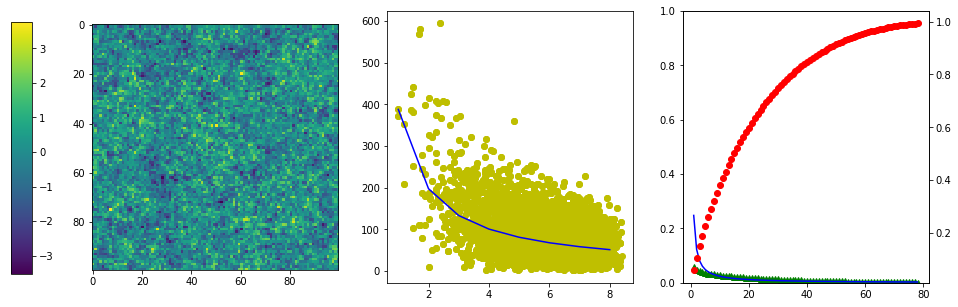

Size: 100 | Alpha: 2.000
Estimated Alpha: 2.009 | r^2: 0.392
Estimated Beta: 1.333 | r^2: 0.955


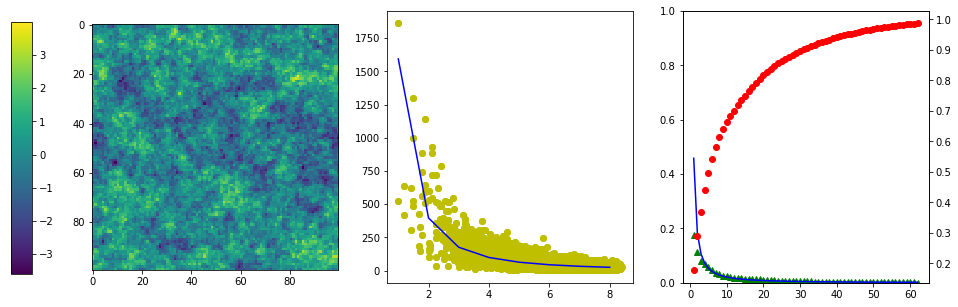

Size: 100 | Alpha: 4.000
Estimated Alpha: 4.022 | r^2: 0.727
Estimated Beta: 2.814 | r^2: 0.957


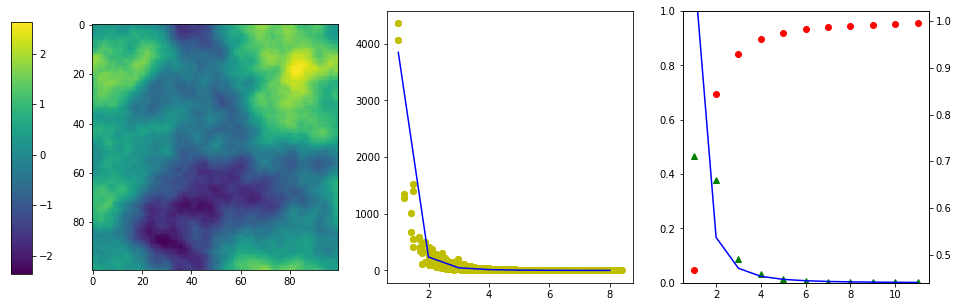

Size: 200 | Alpha: 1.000
Estimated Alpha: 1.019 | r^2: 0.142
Estimated Beta: 0.846 | r^2: 0.821


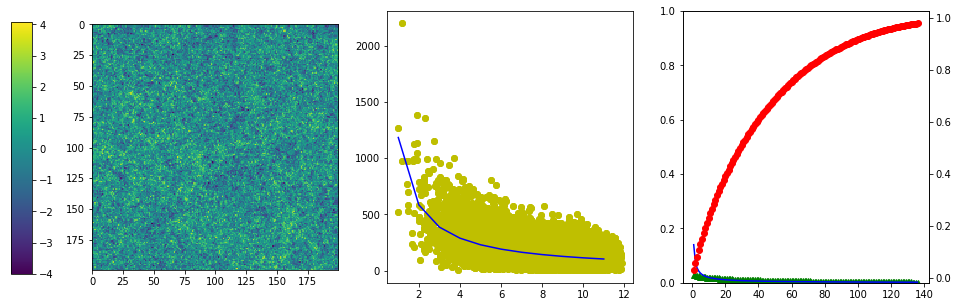

Size: 200 | Alpha: 2.000
Estimated Alpha: 2.012 | r^2: 0.393
Estimated Beta: 1.264 | r^2: 0.988


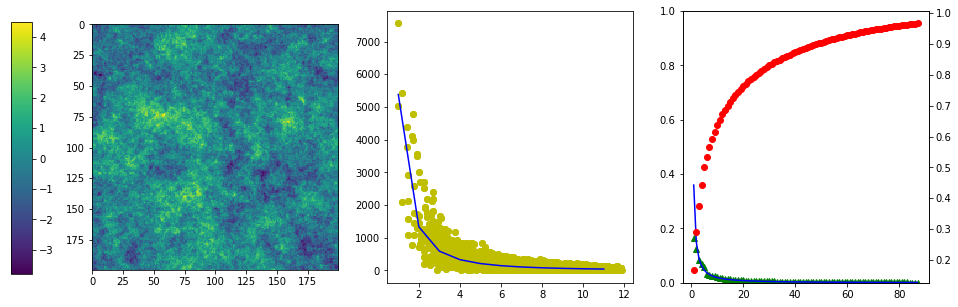

Size: 200 | Alpha: 4.000
Estimated Alpha: 4.001 | r^2: 0.719
Estimated Beta: 3.094 | r^2: 0.933


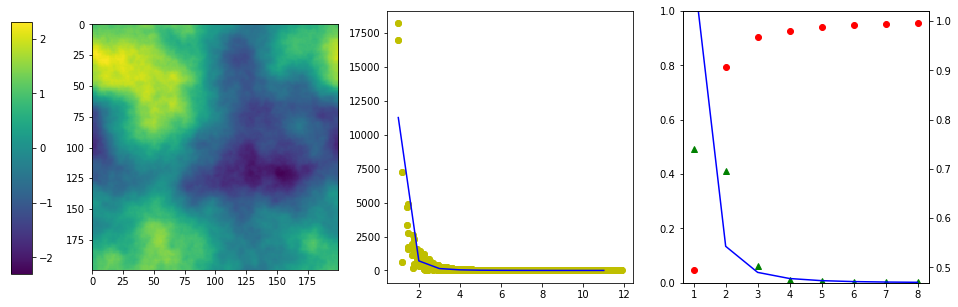

Size: 400 | Alpha: 1.000
Estimated Alpha: 1.011 | r^2: 0.139
Estimated Beta: 0.687 | r^2: 0.869


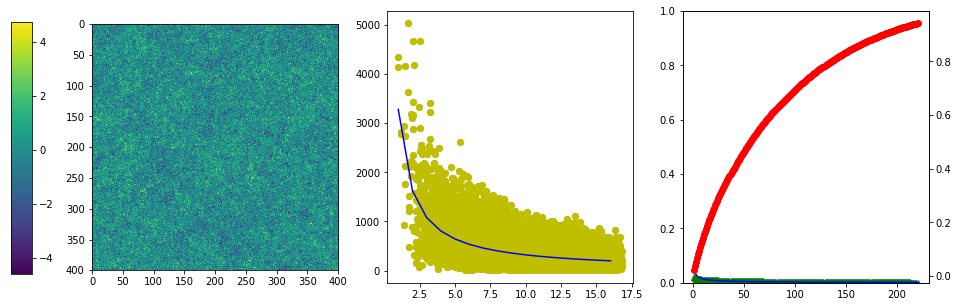

Size: 400 | Alpha: 2.000
Estimated Alpha: 1.989 | r^2: 0.385
Estimated Beta: 1.149 | r^2: 0.998


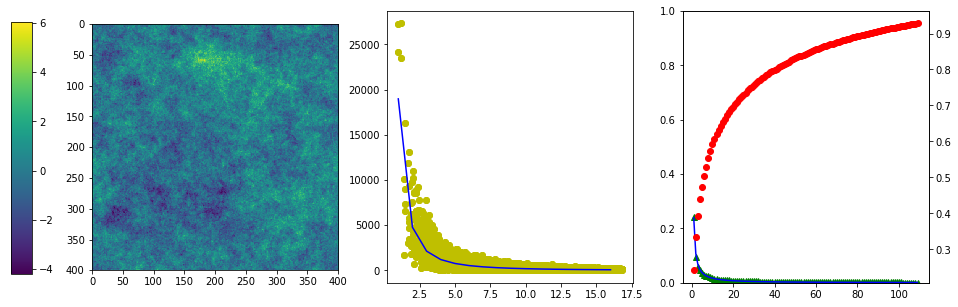

Size: 400 | Alpha: 4.000
Estimated Alpha: 4.019 | r^2: 0.720
Estimated Beta: 2.766 | r^2: 0.970


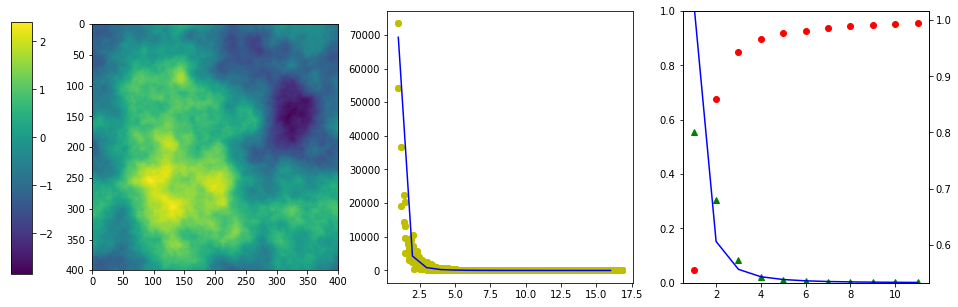

In [24]:
for size in [100, 200, 400]:
    for alpha in [1, 2, 4]:
        data = gaussianRandomSpatialField(alpha, size)
        wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
        estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
        U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
        x, valueList, cumulativeList = explainedVariance(s)
        estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
        print("Size: {:d} | Alpha: {:0.3f}".format(size, alpha))
        print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
        print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
        fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
        im = ax1.imshow(data)
        extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        ax1.axis('off')
        fig.savefig("Results/GaussianRandomFieldSize{:d}Alpha{:d}.pdf".format(size, alpha), bbox_inches=extent, pad_inches=0)
        ax1.axis('on')
        cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax = cbaxes)
        ax2.plot(wavesMasked, fftMasked, "yo")
        ax2.plot(range(1, 1 + int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, 1 + int(max(wavesMasked))), -estimatedAlpha), "b-")
        ax3.plot(x, valueList, "g^")
        ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
        ax3b = ax3.twinx()
        ax3.set_ylim(0, valueList[0])
        ax3.set_ylim(0, 1)
        ax3b.plot(x, cumulativeList, "ro")
        matplotlib.pyplot.show()

### Gaussian Random Spatio-Temporal Field

In many real-world applications, the analysis of a field does not only involve a single _time period_. In fact, it often includes data over multiple weeks, months or years, where the field over the entire time period does not change drastically. Just as there is spatial autocorrelation, there is temporal autocorrelation. The _gaussianRandomSpatialTemporalField_ function generates a 3D matrix where the third dimension represent _time_. In principle, there can be a different level of correlation over time than over space. However, for simplicity, we are using the same $\alpha$ determine the level of autocorrelation in all dimensions.

In [25]:
def gaussianRandomSpatialTemporalField(alpha=2.0, spatialSize=100, temporalSize=60):
    noise = numpy.fft.fftn(numpy.random.normal(size=(spatialSize, spatialSize, temporalSize)))
    mesh = numpy.meshgrid(range(-spatialSize//2, spatialSize//2), range(-spatialSize//2, spatialSize//2), range(-temporalSize//2, temporalSize//2))
    distance = numpy.power(mesh[0], 2, dtype=numpy.float64) + numpy.power(mesh[1], 2, dtype=numpy.float64) + numpy.power(mesh[2], 2, dtype=numpy.float64)
    distance[spatialSize//2, spatialSize//2, temporalSize//2] = numpy.inf
    amplitude = numpy.power(distance, -alpha/4.0)
    amplitude = numpy.fft.ifftshift(amplitude)
    result = numpy.fft.ifftn(noise * amplitude).real
    result = (result - numpy.mean(result)) / numpy.std(result)
    return result

We can plot various _time periods_ of a spatial field next to each other, which will show how the field evolves in time. These changes will occur rapidly for smaller $\alpha$ and more slowly for larger $\alpha$. The _estimateGaussianPowerLaw_ function can, again, be used to estimate $\alpha$ based on the data.

Spatial Size: 100 | Alpha: 1.000
Estimated Alpha: 1.026 | r^2: 0.139


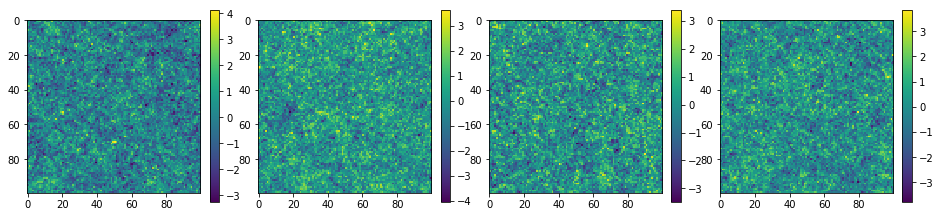

Spatial Size: 100 | Alpha: 2.000
Estimated Alpha: 1.996 | r^2: 0.383


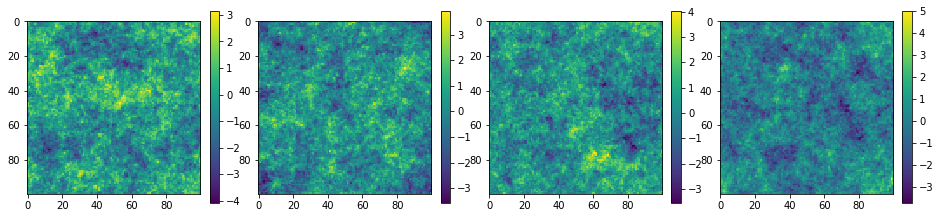

Spatial Size: 100 | Alpha: 4.000
Estimated Alpha: 3.980 | r^2: 0.708


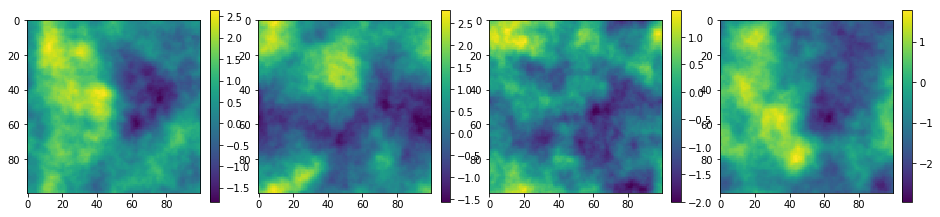

Spatial Size: 200 | Alpha: 1.000
Estimated Alpha: 0.974 | r^2: 0.129


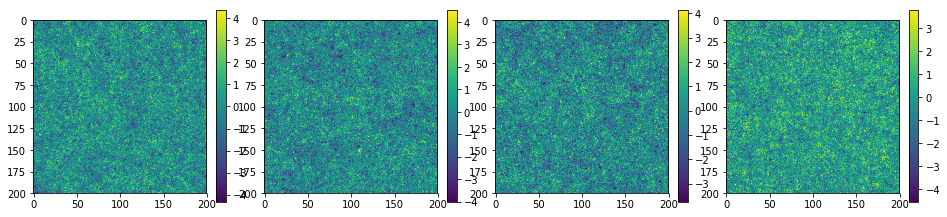

Spatial Size: 200 | Alpha: 2.000
Estimated Alpha: 1.992 | r^2: 0.381


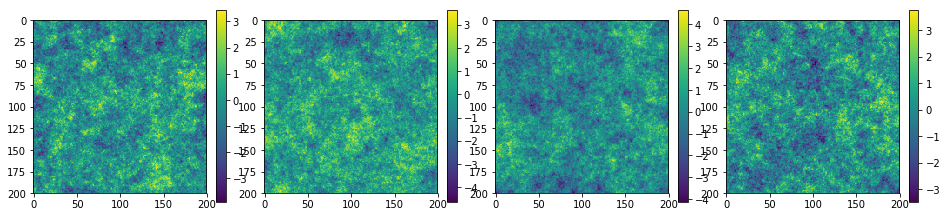

Spatial Size: 200 | Alpha: 4.000
Estimated Alpha: 3.993 | r^2: 0.715


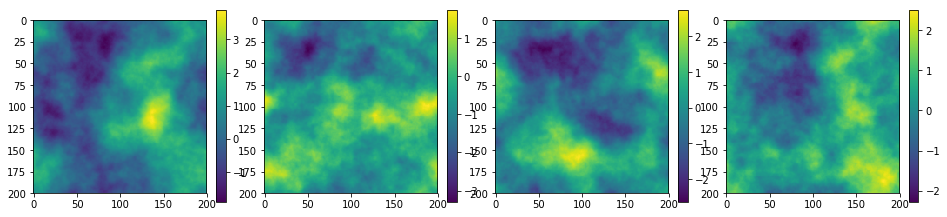

Spatial Size: 400 | Alpha: 1.000
Estimated Alpha: 0.997 | r^2: 0.137


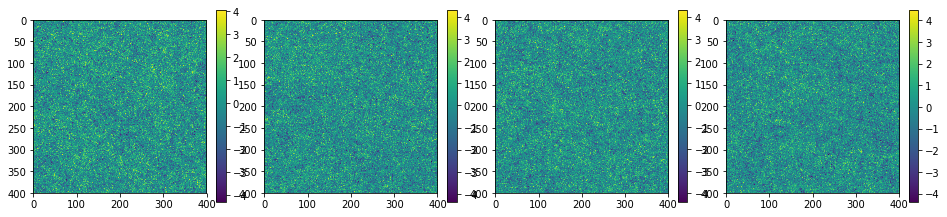

Spatial Size: 400 | Alpha: 2.000
Estimated Alpha: 1.998 | r^2: 0.388


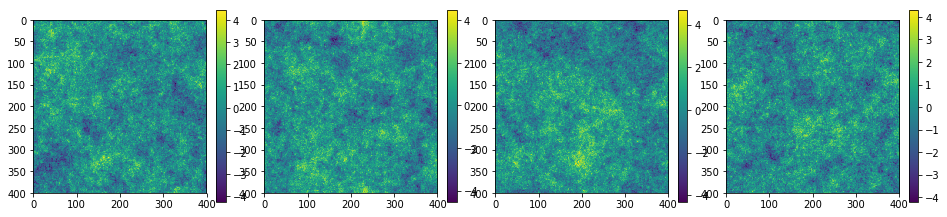

Spatial Size: 400 | Alpha: 4.000
Estimated Alpha: 4.004 | r^2: 0.718


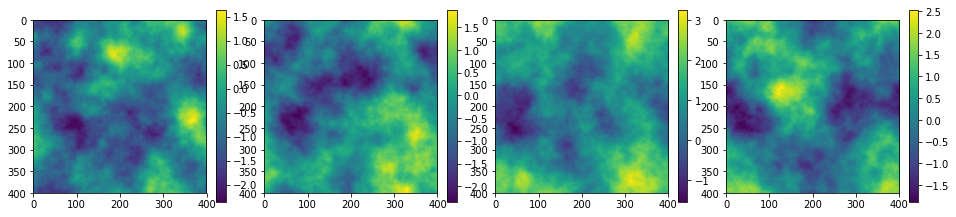

In [26]:
temporalSize=4
for spatialSize in [100, 200, 400]:
    for alpha in [1, 2, 4]:
        data = gaussianRandomSpatialTemporalField(alpha, spatialSize, temporalSize)
        estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data)
        print("Spatial Size: {:d} | Alpha: {:0.3f}".format(spatialSize, alpha))
        print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
        matplotlib.pyplot.figure(figsize=(20, 20))
        for i in range(temporalSize):
            matplotlib.pyplot.subplot(1, temporalSize + 1, i + 1)
            matplotlib.pyplot.imshow(data[:, :, i])
            matplotlib.pyplot.colorbar(fraction=0.05)
        matplotlib.pyplot.show()

In order to keep our _Jupyter Notebook_ running efficiently, it is important to actively _collect garbage_.

In [27]:
_ = gc.collect()

### Moran's I

There are multiple measures of spatial autocorrelation. One which is frequently using in the _geosciences_ is Moran's $I$ [7, 10, 13, 14, 16]. Altough, the Python module _pysal_ has a function to determine Moran's $I$, it is very slow, especially for kernels with a large bandwidth.

Therefore, let's define a function which approximates Moran's $I$, for 2D spatial fields such as ours and for a uniform kernel. As Moran's $I$ examines the similarity between neighbouring cells, let's first define the _matrixToGrid_ function which can cut a spatial field into multiple smaller sections of neighbouring cells.

The _sumOfCovariance_ function simply sums the covariance matrix of a vector over the upper triangle.

In [28]:
def sumOfCovariance(data):
    return (numpy.sum(numpy.outer(data, data)) - numpy.dot(data, data)) / data.shape[0] / (data.shape[0] - 1)

The _approximateMoransI_ functions cuts a 2D spatial dataset into multiple squares of size equal to the _bandwidth_. Then, the covariances of all of these squares is summed.

In [29]:
def approximateMoransI(data, bandwidth=4):
    bandwidth += 1
    h, _, data = normaliseShape(data, bandwidth, bandwidth)
    data = standardiseMatrix(data)
    matrixToVector = data.reshape(h//bandwidth, bandwidth, -1, bandwidth).swapaxes(1, 2).reshape(-1, bandwidth**2)
    return numpy.mean(numpy.apply_along_axis(sumOfCovariance, 1, matrixToVector))

Let's test and compare Moran's $I$ and our approximation function. The function for Moran's $I$ in the _pysal_ module requires a weight matrix. To create this matrix using a uniform kernel with some bandwidth, the indices of the spatial points are used. Obviously, we need to use a similar bandwidth in our approximation. Finally, the _testApproximateMoransI_ function generates a 2D spatial field and determines Moran's $I$ and the approximation.

In [30]:
def testApproximateMoransI(size=60, alpha=2, bandwidth=4):
    data = gaussianRandomSpatialField(alpha, size)
    y = data.flatten()
    meshX, meshY = numpy.meshgrid(numpy.arange(size), numpy.arange(size))
    latticeCoordinates = numpy.column_stack((meshY.ravel(), meshX.ravel()))
    w = pysal.Kernel(latticeCoordinates, bandwidth=bandwidth, function='uniform')
    mi = pysal.Moran(y, w, permutations=0)
    return mi.I, approximateMoransI(data, bandwidth=bandwidth)

The following two numbers are Moran's $I$ and its approximation. By varying the size, the $\alpha$ and the bandwidth we can find their dependency on these parameters. It seems our approximation gives a good representation of Moran's $I$. Initially it overestimated the measure slightly, but incrementing the bandwidth has improved this.

In [31]:
loop(testApproximateMoransI)

array([0.48007343, 0.48507041])

Moran's $I$ shows substantial dependency on size. We will not explore this further here, but it would be interesting to investigate this effect in the future. Our approximation shows the same effect.

In [32]:
loop(testApproximateMoransI, {"size": 40})

array([0.4301791 , 0.43496585])

In [33]:
loop(testApproximateMoransI, {"size": 100})

array([0.55509687, 0.55581226])

When $\alpha$ is smaller, the _Gaussian Random Field_ has smaller scale structure. It is closer to randomness and has less autocorrelation. As expected, the effect can be seen in the two measures of autocorrelation.

In [34]:
loop(testApproximateMoransI, {"alpha": 0.5})

array([0.05401636, 0.03800355])

In [35]:
loop(testApproximateMoransI, {"alpha": 1})

array([0.14492997, 0.140761  ])

In [36]:
loop(testApproximateMoransI, {"alpha": 2})

array([0.49766717, 0.50464122])

In [37]:
loop(testApproximateMoransI, {"alpha": 3})

array([0.81700495, 0.81772087])

In [38]:
loop(testApproximateMoransI, {"alpha": 4})

array([0.92877279, 0.92552167])

Larger bandwidths capture more variation, leading to smaller values of Moran's $I$. This can also be seen in our simulations. The appropriate bandwidth to use depends on the level of autocorrelation in the dataset. Only comparisons of Moran's $I$ using the same bandwidth make sense.

In [39]:
loop(testApproximateMoransI, {"bandwidth": 2})

array([0.66152132, 0.60312753])

In [40]:
loop(testApproximateMoransI, {"bandwidth": 6})

array([0.34769223, 0.38533408])

To find a more precise relation between the $\alpha$ of a _Gaussian Random Fields_ and the other measures of spatial autocorrelation, let's generate various fields for different sizes and different $\alpha$'s. We can then calculate $\beta$ and Moran's $I$ as a function of $\alpha$.

In [41]:
def testMoransIAndBeta(size=200, alpha=2, bandwidth=10):
    data = gaussianRandomSpatialField(alpha, size)
    U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
    estimatedBeta, _, _ = estimateSingularValuesPowerLaw(s)
    mi = approximateMoransI(data, bandwidth=bandwidth)
    return mi, estimatedBeta

In [42]:
def plotMoransIAndBeta(size=200):
    alphas = numpy.arange(0.25, 4.1, 0.25)
    line1 = []
    line2 = []
    for alpha in alphas:
        value = loop(testMoransIAndBeta, {"size": size, "alpha": alpha})
        line2.append(value[0])
        line1.append(value[1])
    matplotlib.pyplot.plot(alphas, line1)
    matplotlib.pyplot.plot(alphas, line2)
    matplotlib.pyplot.legend([r"Moran's $I$", r"$\beta$"])
    matplotlib.pyplot.xlabel(r"$\alpha$")
    matplotlib.pyplot.ylabel("autocorrelation")
    matplotlib.pyplot.savefig("Results/plotMoransIAndBeta.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

The plot below indeed shows the positive correlation of $\alpha$, Moran's $I$ and $\beta$. Note that we used a bandwidth equal to $10$ gridpoints for the kernel in Morans' $I$. Subsequent analyses will define the scale of the field's structure in terms of $\alpha$. This plot can help _translate_ this measure to the other measures of autocorrelation.

In real world applications, datasets are not _Gaussian Random Fields_ and the relation between $\alpha$, Moran's $I$ and $\beta$ will not be so precise. Furthermore. due to the size dependency of Moran's $I$, this plot does not describe the entire picture even for the _Gaussian Random Fields_ case. Nonetheless, it does provide an idea of the relations between the three measures.

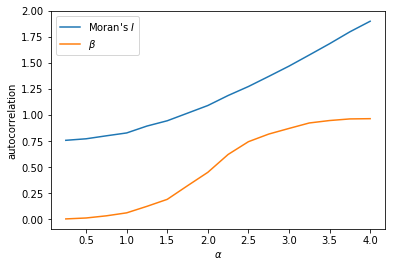

In [43]:
plotMoransIAndBeta()

In [44]:
_ = gc.collect()

## Efficient SVD Techniques

This section will discuss four techniques to analyse large datasets efficiently using SVD, by exploiting rank deficiency and autocorrelation. We will generate various _Gaussian Random Fields_, apply our techniques and compare the reults.

One method to capture the similarity between two field is to determine the norm of the difference between these two datasets. The $L2$ norm, also known as the _Frobenius norm_, simply captures the total variance in the dataset. By dividing the variance in the difference of two datasets with the variance of the original dataset, a simple measure of their (dis)similarity is established. Note that two _Gaussian Random Fields_, on average, will have a dissimilarity of 1.41 (i.e. $\sqrt2$) as they are independently drawn and orthogonal to each other.

Another measure which could have been used, is the _Pearson correlation_ between the two datasets. Two identical fields have a correlation equal to $1$ and two independently drawn _Gaussian Random Fields_ have a correlation of $0$. We leave this measure for further research.

In this work, the term _efficiency_ is related to the concept of rank deficiency. A calculation is called _efficient_ if it never requires the construction of a rank deficient (i.e. an unnecessarily large) intermediate matrix.

### Efficient Exact Norm Difference via SVD

In real-world application, one often wants to find the norm of the difference between two fields. This can be done by subtracting one matrix from the other and calculating the norm. However, for large matrices, a more efficient method is available when a rank decomposition, such as the SVD, is already known. The _normDifferenceFromUSVs_ function can take such input SVDs and determine the norm of their difference in an efficient manner, provided the number of singular values is small. The result is mathematically identical to the full calculation, which means that any error will be of the order of machine-precision.

In [45]:
def normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2):
    if U1.shape != U2.shape or s1.shape != s2.shape or Vt1.shape != Vt2.shape:
        print("Error: shapes do not match.")
        return 0
    AA = s1 @ s1
    BB = s2 @ s2
    AB = s1 @ numpy.multiply(U1.T @ U2, Vt1 @ Vt2.T) @ s2
    return math.sqrt(AA + BB - 2 * AB)

If one is interested in the percentage difference of the second matrix compared with the first, the _percentageNormDifferenceFromUSVs_ function will use the output of the previous function and compare this to the norm of the first matrix, which is simply the sum of its singular values squared.

In [46]:
def percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2):
    return normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2) / math.sqrt(s1 @ s1)

The image below depicts the calculations performed in the functions above. It shows that for rank deficient datasets, i.e. ones with small numbers of singular modes, the calculation never requires the construction of an inefficiently large intermediate matrix.

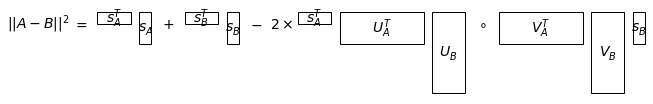

In [47]:
matrixDescription = [
    {"type":"Symbol", "symbol":r"$||A-B||^{2}$", "width":0.5},
    {"type":"Symbol", "symbol":r"$=$"},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{A}^{T}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{A}^{}$"},
    {"type":"Symbol", "symbol":"+"},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{B}^{T}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{B}^{}}$"},
    {"type":"Symbol", "symbol":r"$-$"},
    {"type":"Symbol", "symbol":r"$2 \times$", "width":0.3},
    {"type":"Matrix", "width":0.4, "height":0.15, "text":r"$s_{A}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.4, "text":r"$U_{A}^{T}$"},
    {"type":"Matrix", "width":0.4, "height":1, "text":r"$U_{B}^{}$"},
    {"type":"Symbol", "symbol":r"$\circ$"},
    {"type":"Matrix", "width":1, "height":0.4, "text":r"$V_{A}^{T}$"},
    {"type":"Matrix", "width":0.4, "height":1, "text":r"$V_{B}^{}$"},
    {"type":"Matrix", "width":0.15, "height":0.4, "text":r"$s_{B}^{}$"}
]
plotMatrixMultiplication(matrixDescription, "Results/normDifferenceFromUSVs.pdf")

To verify experimentally that the _normDifferenceFromUSVs_ function indeed produces an output identical to the full norm difference, let's generate a _Gaussian Random Field_ and run both types of calculation.

In [48]:
def testNormDifferenceFromUSVs(size=200, alpha=2):
    matrix1 = gaussianRandomSpatialField(alpha, size)
    matrix2 = gaussianRandomSpatialField(alpha, size)
    matrixDifference = matrix1 - matrix2
    normDifference = scipy.linalg.norm(matrixDifference)
    U1, s1, Vt1 = scipy.linalg.svd(matrix1, full_matrices = False)
    U2, s2, Vt2 = scipy.linalg.svd(matrix2, full_matrices = False)
    normDifference2 = normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)
    return numpy.isclose(normDifference, normDifference2)

As expected, the results are identical up to machine-precision.

In [49]:
testNormDifferenceFromUSVs()

True

In [50]:
_ = gc.collect()

### Efficient Exact SVD via QR Decomposition

In real-world applications, it may be interesting to find to find the relation between two fields. This can be done by performing an SVD of the cross-correlation matrix of these two fields. Typically, the two input datasets have the various spatial gridpoint as rows and the sample of recorded values over time as columns. Multiplying two fields by row gives the cross-correlation matrix.

However, for highly rectangular matrices, when there are many spatial gridpoint but few temporal samples, the resulting cross-correlation matrix is rank deficient and inefficiently large. The _qrProductSVD_ function can take such input data and perform an SVD in an efficient manner [2, 5, 15]. The result is mathematically identical to the full SVD, which means that the difference will be at machine-precision.

In [51]:
def qrProductSVD(A, B):
    # Based on a suggestion from Mark Tygert during personal communication [15]
    QA, RA = scipy.linalg.qr(A, mode = "economic")
    QB, RB = scipy.linalg.qr(B, mode = "economic")
    C = RA @ RB.T
    UC, s, VCt = scipy.linalg.svd(C, full_matrices = False)
    U = QA @ UC
    Vt = VCt @ QB.T
    return U, s, Vt

The following figure shows the steps in this calculation. Note that the rank decomposition leads to the same SVD output without ever creating the rank deficient cross-correlation matrix.

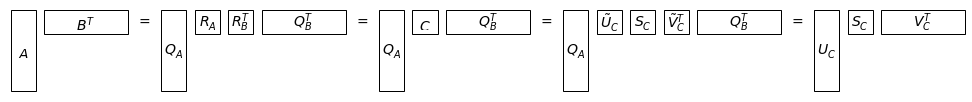

In [52]:
matrixDescription = [
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$B_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$R_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$R_{B}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$C_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{C}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{C}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{C}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/qrProductSVD.pdf")

To verify experimentally that the _qrProductSVD_ function indeed produces an output identical to the full SVD, let's generate a _Gaussian Random Spatio-Temporal Field_ and run both types of SVD.

In [53]:
def testQRProductSVD(spatialSize=60, temporalSize=40, alpha=2):
    matrixBoth = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrix1 = matrixBoth[:, :, :temporalSize]
    matrix2 = matrixBoth[:, :, temporalSize:]
    matrixFlattened1 = matrix1.reshape(spatialSize * spatialSize, temporalSize)
    matrixFlattened2 = matrix2.reshape(spatialSize * spatialSize, temporalSize)
    productMatrix = matrixFlattened1 @ matrixFlattened2.T
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    reconstructedMatrix = usvToMatrix(U, s, Vt)
    return numpy.allclose(productMatrix, reconstructedMatrix)

As expected, the results are identical up to machine-precision.

In [54]:
testQRProductSVD()

True

In [55]:
_ = gc.collect()

### Efficient Approximate SVD via Spatial Coarsening

Although the _qrProductSVD_ function works well for two rectangular matrices, sometimes the input data is large and square. Other methods can be used which provide an approximate answer. Given a desired level of accuracy, reducing the datasets before performing the SVD may speed up the analysis.

#### Single Spatial Field via Spatial Coarsening

When a field has large scale structure, the values of neighbouring cells do not change drastically. This is what autocorrelation means. As such, perhaps neighbouring cells can be averaged together to produce a smaller dataset which still faithfully describes the original field. The _coarsenMatrix_ function first cuts the input matrix into smaller sections and then averages each section, reducing the spatial size. It then knits the sections back together, resulting in a matrix which is $level^{2}$ times smaller.

In [56]:
def coarsenMatrix(array, level):
    h, w, array = normaliseShape(array, level, level)
    arrayReshaped = array.reshape((h // level, level, w // level, level))
    return numpy.nanmean(arrayReshaped, axis=(1,3))

The _uncoarsenMatrix_ function does the reverse of the previous function. It enlarges each cells, resulting in a matrix which is $level^{2}$ times bigger.

In [57]:
def uncoarsenMatrix(matrix, level):
    return numpy.repeat(numpy.repeat(matrix, level, axis=0), level, axis=1)

To see the effect of spatial coarsening, let's generate a _Gaussian Random Field_ and plot it together with a coarsened version. To be able to compare the two matrices, they need to be of the same size. Therefore, we also uncoarsen the coarsened matrix. The difference with the original field is shown in a plot. The norm of the difference between the uncoarsened matrix and the original shows the amount of information lost in the coarsening process.

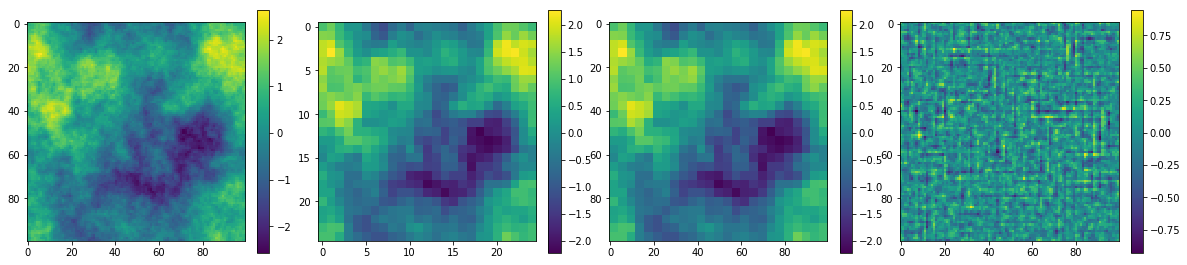

Norm original matrix: 99.99999999999999
Norm coarsened matrix: 24.359937699419124
Norm uncoarsened matrix: 97.43975079767648
Norm of their difference: 22.483215172361383
Percentage difference: 0.22483215172361387


In [58]:
matrix = gaussianRandomSpatialField(alpha=3, size=100)
coarsenedMatrix = coarsenMatrix(matrix, 4)
uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrix, 4)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(coarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(uncoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(uncoarsenedMatrix - matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(matrix)
normDifference = scipy.linalg.norm(uncoarsenedMatrix - matrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm coarsened matrix: " + str(scipy.linalg.norm(coarsenedMatrix)))
print("Norm uncoarsened matrix: " + str(scipy.linalg.norm(uncoarsenedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testSingleSpatialFieldViaCoarsening_ function determines the percentage of the information lost in a coarsening process for matrices of various size and $\alpha$'s, and at various window sizes. Typically, one is mostly interested in the largest few singular modes. These are the least affected by the coarsening process, as they describe large scale structure within the field. The function includes the parameter _modes_ which reduces the input and output matrix to the largest _modes_ singular values/vectors, to be able to see the information loss specifically on these modes.

In [59]:
def testSingleSpatialFieldViaCoarsening(size=200, alpha=2, level=4, modes=4):
    matrix = gaussianRandomSpatialField(alpha=alpha, size=size)
    coarsenedMatrix = coarsenMatrix(matrix, level)
    coarsenedMatrixReduced = reduceMatrix(coarsenedMatrix, modes)
    uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrixReduced, level)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(uncoarsenedMatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

At a coarsening level of 4, the coarsened matrix is 16 times smaller than the original. One could expect a large portion of the information to be lost, but this is not necessarily the case.

In [60]:
loop(testSingleSpatialFieldViaCoarsening)

0.24748374558379044

There is quite a large effect of size on the error. The effect also increases with higher autocorrelation. The size dependency may be similar to the one found for Moran's $I$. We will not explore this here, but it is an interesting area for further investigation.

In [61]:
loop(testSingleSpatialFieldViaCoarsening, {"size": 100})

0.38250876281721186

In [62]:
loop(testSingleSpatialFieldViaCoarsening, {"size": 400})

0.16091254665899427

The effect of $\alpha$ is obviously important. Smaller $\alpha$ means smaller scale structure. Such structures will get lost during the coarsening, leading to larger differences with the original.

In [63]:
loop(testSingleSpatialFieldViaCoarsening, {"alpha": 1})

0.7496204101215342

In [64]:
loop(testSingleSpatialFieldViaCoarsening, {"alpha": 4})

0.06037119700695481

Clearly, the level of coarsening is fundamental. Note that the size of the reduced matrix is related to the square of the coarsening level.

In [65]:
loop(testSingleSpatialFieldViaCoarsening, {"level": 2})

0.14119641900403734

In [66]:
loop(testSingleSpatialFieldViaCoarsening, {"level": 10})

0.44788000534563555

Finally, as mentioned, one is usually only interested in the largest few singular modes. The largest modes at least affected by coarsening. When more modes are included in the comparison, the percentage of relevent information lost increases.

In [67]:
loop(testSingleSpatialFieldViaCoarsening, {"modes": 2})

0.2220714766711763

In [68]:
loop(testSingleSpatialFieldViaCoarsening, {"modes": 8})

0.306191347946288

Let's plot the information loss as a function of the coarsening level for various $\alpha$'s.

In [69]:
def plotSingleSpatialFieldViaCoarsening(size=480, modes=4):
    alphas = numpy.arange(1, 3.1, 0.25)
    levels = numpy.concatenate((numpy.arange(2, 12.1, 2, dtype=int), numpy.arange(16, 24.1, 4, dtype=int)))
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testSingleSpatialFieldViaCoarsening, {"size": size, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 100)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldViaCoarsening.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

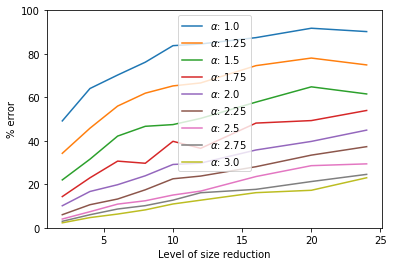

In [70]:
plotSingleSpatialFieldViaCoarsening()

Note how similar this plot is to one of the inverse of Moran's $I$. Applying our approximation function of Moran's $I$ to a dataset will give quite an accurate measure of the error incurred when coarsening at various levels.

In [71]:
def plotSingleSpatialFieldsMoransI(size=432):
    alphas = numpy.arange(1, 3.1, 0.25)
    levels = numpy.concatenate((numpy.arange(2, 4.1, 2, dtype=int), numpy.arange(6, 24.1, 6, dtype=int)))
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testMoransIAndBeta, {"size": size, "alpha": alpha, "bandwidth": level})[0]
            line.append(1 - value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 1)
    matplotlib.pyplot.xlabel("Bandwidth")
    matplotlib.pyplot.ylabel(r"Inverse of Moran's $I$")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldsMoransI.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

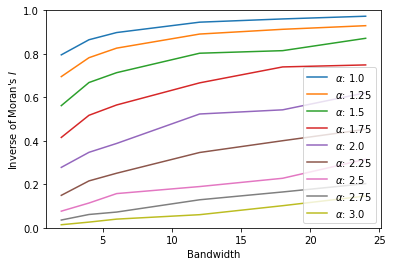

In [72]:
plotSingleSpatialFieldsMoransI()

Let's also plot the information loss as a function of the coarsening level for various _modes_.

In [73]:
def plotSingleSpatialFieldViaCoarsening2(size=480, alpha=2):
    modesList = numpy.arange(1, 11.1, 2, dtype=int)
    levels = numpy.arange(4, 24.1, 4, dtype=int)
    for modes in modesList:
        line = []
        for level in levels:
            value = loop(testSingleSpatialFieldViaCoarsening, {"size": size, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend(["modes: " + str(modes) for modes in modesList])
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldViaCoarsening2.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

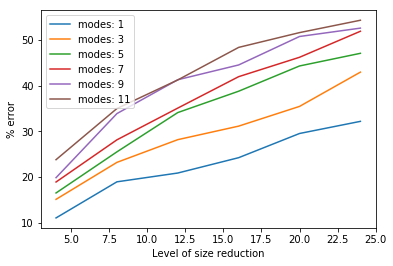

In [74]:
plotSingleSpatialFieldViaCoarsening2()

In [75]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

In the analysis of spatio-temporal fields, the spatial part of each time period can be coarsened. The _coarsenMatrix3D_ function simply loops over the temporal dimension and coarsens the spatial part.

In [76]:
def coarsenMatrix3D(array, level):
    h, w, d = array.shape
    coarsenedMatrix3D = numpy.empty((h // level, w // level, d))
    for i in range(d):
        coarsenedMatrix3D[:, :, i] = coarsenMatrix(array[:, :, i], level)
    return coarsenedMatrix3D

In a _CCA_ or _MCA_, the spatio-temporal fields are flattened, scaled and multiplied to obtain the cross-correlation matrix. To be able to compare this result with the original calculation, we need to be able to undo the effect of coarsening for such a product matrix. The output of the coarsened SVD can be uncoarsened directly. The _uncoarsenUSV_ function returns the _U_, _s_ and _V_ as if the coarsening had not occured. Note that the vectors are also re-normalised.

In [77]:
def uncoarsenUSV(U, s, Vt, level, height):
    h, w = U.shape
    UReconstructed = numpy.repeat(numpy.repeat(numpy.vsplit(U, h / height), level, axis=0).reshape(-1, w), level, axis=0) / level
    h, w = Vt.shape
    VtReconstructed = numpy.repeat(numpy.repeat(numpy.array(numpy.hsplit(Vt, w / height)).swapaxes(0, 1), level, axis=1).reshape(h, -1), level, axis=1) / level
    s = s * level**2
    return UReconstructed, s, VtReconstructed

To see the effect of spatio-temporal coarsening, let's generate a _Gaussian Random Field_ and plot it together with a coarsened version. To be able to compare the two matrices, they need to be of the same size. Therefore, we also uncoarsen the coarsened matrix. The difference with the original field is shown in a plot. To determine precisely how much information is lost during the coarsening, we should look at the variance of the datasets. The norm of the difference between the uncoarsened matrix and the original is the amount of information lost in the coarsening process.

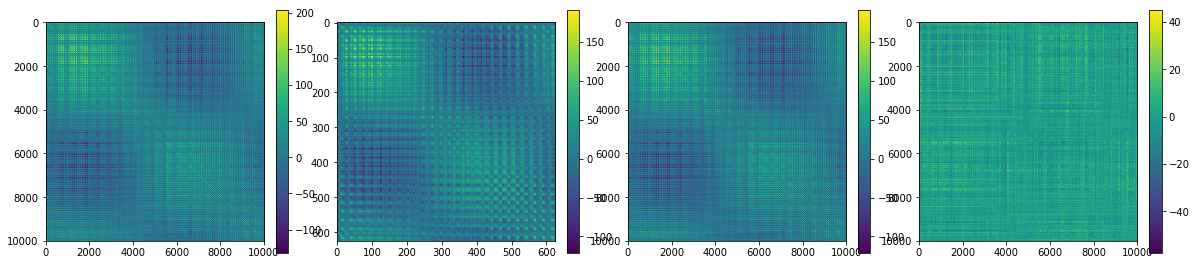

Norm original matrix: 318164.935332283
Norm coarsened matrix: 19576.92350567314
Norm uncoarsened matrix: 313230.77609086497
Norm of their difference: 55815.83094937721
Percentage difference: 0.17543049139304


In [78]:
spatialSize=100
temporalSize=60
alpha=4
level=4
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
reconstructedMatrix = usvToMatrix(U1, s1, Vt1)
matrixCombinedCoarsened = coarsenMatrix3D(matrixCombined, level)
matrixCoarsened1, matrixCoarsened2 = splitAndFlattenSpatialTemporalField(matrixCombinedCoarsened)
U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
reconstructedCoarsenedMatrix = usvToMatrix(U2, s2, Vt2)
U2, s2, Vt2 = uncoarsenUSV(U2, s2, Vt2, level, spatialSize // level)
reconstructedUncoarsenedMatrix = usvToMatrix(U2, s2, Vt2)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(reconstructedCoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(reconstructedUncoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(reconstructedUncoarsenedMatrix - reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(reconstructedMatrix)
normDifference = scipy.linalg.norm(reconstructedMatrix - reconstructedUncoarsenedMatrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm coarsened matrix: " + str(scipy.linalg.norm(reconstructedCoarsenedMatrix)))
print("Norm uncoarsened matrix: " + str(scipy.linalg.norm(reconstructedUncoarsenedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testProductSpatialTemporalFieldsViaCoarsening_ function determines the percentage of the information lost in a coarsening process for matrices of various sizes and $\alpha$'s, and at various levels of coarsening. The two input matrices used here are similar, as they are generated by the same _Gaussian Random Process_. Therefore, they will correlate highly and the bases in which they are best described will be similar. In principle, any two datasets can be analysed and the amount of information lost during the coarsening process will likely depend on the similarity between the two datasets. This is one aspect which we do not cover here and leave for further research.

In [79]:
def testProductSpatialTemporalFieldsViaCoarsening(spatialSize=100, temporalSize=60, alpha=4, level=4, modes=8):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U1, s1, Vt1 = reduceUSV(U1, s1, Vt1, modes)
    matrixCombinedCoarsened = coarsenMatrix3D(matrixCombined, level)
    matrixCoarsened1, matrixCoarsened2 = splitAndFlattenSpatialTemporalField(matrixCombinedCoarsened)
    U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, modes)
    U2, s2, Vt2 = uncoarsenUSV(U2, s2, Vt2, level, spatialSize // level)
    return percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)

Due to the multiplication step in this analysis, the typical error as a result of coarsening is larger than before.

In [80]:
loop(testProductSpatialTemporalFieldsViaCoarsening)

0.19768602949457925

One could vary both the spatial and the temporal size and examine the effect of the amount of information lost. For simplicity, we only vary the temporal size, which seems to not have a large effect.

In [81]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"temporalSize": 20})

0.1887448882124466

In [82]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"temporalSize": 100})

0.1828077880866835

As before, $\alpha$ plays an important part, with larger $\alpha$'s leading to a less error after coarsening.

In [83]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"alpha": 2})

0.8668973716209702

In [84]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"alpha": 6})

0.09405195841813799

The result of varying the level of coarsening is shown below.

In [85]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"level": 2})

0.09335582444822131

In [86]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"level": 10})

0.40876381514241034

Finally, we can again examine the effect of taking into account more or fewer modes.

In [87]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"modes": 4})

0.18603951363991372

In [88]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"modes": 16})

0.2035169147315775

Let's plot the information loss as a function of the coarsening level for various $\alpha$'s. The spatial size is set to a common mutiple of the levels, so that coarsening is straightforward.

In [89]:
def plotProductSpatialTemporalFieldsViaCoarsening(modes=8):
    alphas = numpy.arange(1, 5.1, 0.5)
    levels = [2, 4, 8, 12, 16, 24]
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testProductSpatialTemporalFieldsViaCoarsening, {"spatialSize": 96, "alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 105)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotProductSpatialTemporalFieldsViaCoarsening.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

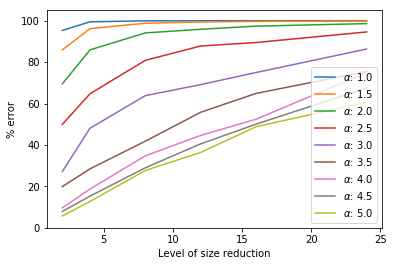

In [90]:
plotProductSpatialTemporalFieldsViaCoarsening()

In [91]:
_ = gc.collect()

### Efficient Approximate SVD via Dimensionality Reduction

The spatial coarsening process is intuitive and easy to implement. It is not, however, the most efficient way to reduce the size of a dataset. Dimensionality reduction refers to discarding modes which contribute little to the variance in a dataset. An SVD is precisely the procedure used to find modes which explain as much variance as possible. Discarding the smallest singular values/vectors is, therefore, the most efficient form of dimensionality reduction [6]. Performing an SVD on a large dataset, especially when it is stored out-of-core, is computationally costly. The Randomised Dimensionality Reduction process is far more efficient [9, 11, 12].

#### Single Spatial Field via Randomised Dimensionality Reduction

The _reduceSizeRandomisedSquare_ function reduces the input matrix to a smaller square matrix of _l_ by _l_. It also gives two projection matrices which can bring the rows and columns of this smaller matrix back to the bases of the original input. To make the result more precise, the procedure can be repeated multiple times. The parameter _i_ indicates how many loops are performed.

In [92]:
def reduceSizeRandomisedSquare(A, i, l):
    # Based on [11]
    h, w = A.shape
    AW = A @ numpy.random.normal(0, 1, (w, l))
    H, RH = scipy.linalg.qr(AW, mode = "economic")
    ATH = A.T @ H
    W, RW = scipy.linalg.qr(ATH, mode = "economic")
    for _ in range(i):
        AW = A @ W
        H, RH = scipy.linalg.qr(AW, mode = "economic")
        ATH = A.T @ H
        W, RW = scipy.linalg.qr(ATH, mode = "economic")
    L = H.T @ A @ W
    return H, L, W

The _reconstructSquareRandomisedSizeReducedMatrix_ function can take the output of the previous function and approximately reconstruct the original matrix.

In [93]:
def reconstructSquareRandomisedSizeReducedMatrix(H, L, W):
    return H @ L @ W.T

The figure below shows the the SVD in not performed on the large matrix, but on its smaller approximation.

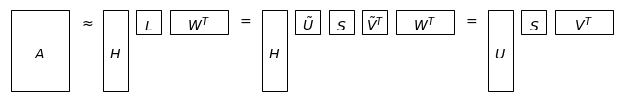

In [94]:
matrixDescription = [
    {"type":"Matrix", "width":0.7, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Symbol", "symbol":r"$\approx$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{}^{T}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$V_{}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/reduceSizeRandomisedSquare.pdf")

To see the effect of dimensionality reduction, let's generate a _Gaussian Random Field_ and plot it together with a reduced version. To determine precisely how much information is lost during the reduction, we should look at the variance of the datasets. The norm of the difference between the reduced matrix and the original relates to the amount of information lost in the reduction process.

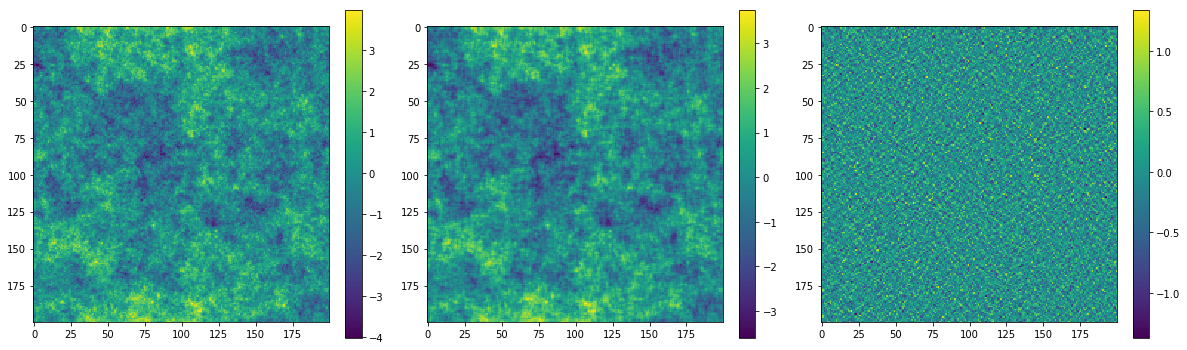

Norm original matrix: 200.0
Norm reduced matrix: 188.76118646431135
Norm of their difference: 66.10003392272566
Percentage difference: 0.33050016961362827


In [95]:
size = 200
alpha = 2
level = 4
i = 1
matrix = gaussianRandomSpatialField(alpha, size)
H, L, W = reduceSizeRandomisedSquare(matrix, i, size // level)
reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, L, W)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(reconstructedmatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(reconstructedmatrix - matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(matrix)
normDifference = scipy.linalg.norm(reconstructedmatrix - matrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm reduced matrix: " + str(scipy.linalg.norm(reconstructedmatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testRandomisedSizeReducedMatrix_ function determines the percentage of the information lost in a reduction process for matrices of various sizes and $\alpha$'s, and at various levels of reduction.

In [96]:
def testRandomisedSizeReducedMatrix(size=200, alpha=2, level=4, i=1, modes=4):
    matrix = gaussianRandomSpatialField(alpha, size)
    matrixReduced = reduceMatrix(matrix, modes)
    H, L, W = reduceSizeRandomisedSquare(matrix, i, size // level)
    LReduced = reduceMatrix(L, modes)
    reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, LReduced, W)
    return scipy.linalg.norm(reconstructedmatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

It is possible for some fields to be represented by matrices of much smaller sizes without losing any substantial amount of information. This makes sense when one realises the singular modes which are removed during the reduction are the smallest ones, described by the tail-end of the power law.

In [97]:
loop(testRandomisedSizeReducedMatrix)

0.005856159072615627

As with Moran's $I$ and the coarsening, there is a substantial effect of size. We will not explore this further.

In [98]:
loop(testRandomisedSizeReducedMatrix, {"size": 100})

0.01735519262593841

In [99]:
loop(testRandomisedSizeReducedMatrix, {"size": 400})

0.0020439637796749485

The tail-end of a power law with a less negative exponent is larger, so the information lost during the reduction of such a field is larger too.

In [100]:
loop(testRandomisedSizeReducedMatrix, {"alpha": 1})

0.1779184850495011

In [101]:
loop(testRandomisedSizeReducedMatrix, {"alpha": 4})

8.545019482548685e-07

Clearly, the level of reduction is important.

In [102]:
loop(testRandomisedSizeReducedMatrix, {"level": 2})

0.0007343731229386075

In [103]:
loop(testRandomisedSizeReducedMatrix, {"level": 8})

0.02190767907199919

As mentioned, the randomised reduction algorithm includes a loop which makes the projections to lower dimensions more precise. The effect, especially from 0 to 1, seems to be large.

In [104]:
loop(testRandomisedSizeReducedMatrix, {"i": 0})

0.17786880609295985

In [105]:
loop(testRandomisedSizeReducedMatrix, {"i": 2})

0.0002542876248408865

In the review article by Halko, Martinsson and Tropp on randomised dimensionality reduction, it is suggested to oversample the reduction [9]. This is because the error introduced in the process is of the same order as the size of the last sampled singular value. If one is interested in the _k_ dominant modes, reducing to a _k + l_, for some small _l_, rank approximation will ensure the first _k_ modes are approximated quite well. Indeed, as seen below, the more modes one is interested in, the larger the difference compared with the original matrix.

In [106]:
loop(testRandomisedSizeReducedMatrix, {"modes": 2})

0.0025914666712433883

In [107]:
loop(testRandomisedSizeReducedMatrix, {"modes": 8})

0.013058961664712593

In [108]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

The Randomised Dimensionality Reduction process can also be applied to the _CCA_ or _MCA_ analysis of two spatio-temporal fields. Similar to the QR Product SVD, it has the advantage that the SVD is applied to a small _l_ by _l_ matrix. The result will be an approximation, but, as we will see, can be close to the real solution.

In [109]:
def randomisedSquareProductSVD(A1, A2, i, l):
    H1, L1, W1 = reduceSizeRandomisedSquare(A1, i, l)
    H2, L2, W2 = reduceSizeRandomisedSquare(A2, i, l)
    C = L1 @ W1.T @ W2 @ L2.T
    UC, s, VCt = scipy.linalg.svd(C, full_matrices = False)
    U = H1 @ UC
    Vt = VCt @ H2.T
    return U, s, Vt

The figure below depicts the calculation. Note that the large, rank deficient matrix product is never formed. The SVD is performed on the smaller _l_ by _l_ matrix.

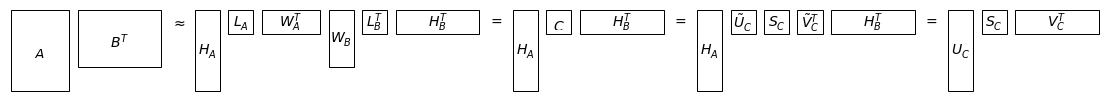

In [110]:
matrixDescription = [
    {"type":"Matrix", "width":0.7, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.7, "text":r"$B_{}^{T}$"},
    {"type":"Symbol", "symbol":r"$\approx$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{A}^{}$"},
    {"type":"Matrix", "width":0.7, "height":0.3, "text":r"$W_{A}^{T}$"},
    {"type":"Matrix", "width":0.3, "height":0.7, "text":r"$W_{B}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{B}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$C_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{C}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{C}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{C}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/randomisedSquareProductSVD.pdf")

To see the effect of dimensionality reduction on such a matrix product, let's generate two _Gaussian Random Fields_ and plot their cross-correlation matrix together with a reduced version. To determine precisely how much information is lost during the reduction, we should look at the variance of the datasets. The norm of the difference between the reduced matrix and the original is the amount of information lost in the reduction process.

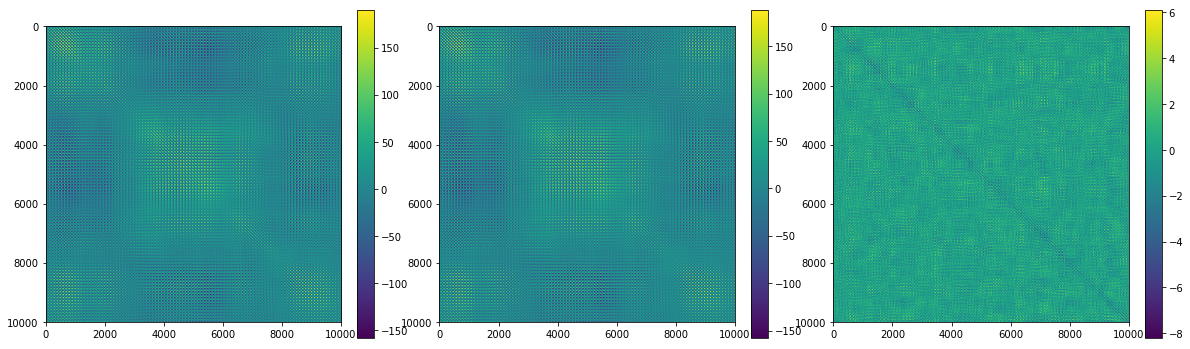

Norm original matrix: 326297.43757358793
Norm reconstructed matrix: 326198.060886914
Norm of their difference: 8052.505243939846
Percentage difference: 0.024678420105961794


In [111]:
spatialSize=100
temporalSize=60
alpha=4
level=4
i=1
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
reducedMatrix = usvToMatrix(U, s, Vt)
U, s, Vt = randomisedSquareProductSVD(matrixFlattened1, matrixFlattened2, i, int(temporalSize / level))
reconstructedMatrix = usvToMatrix(U, s, Vt)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(reducedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(reconstructedMatrix - reducedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(reducedMatrix)
normDifference = scipy.linalg.norm(reconstructedMatrix - reducedMatrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm reconstructed matrix: " + str(scipy.linalg.norm(reconstructedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testRandomisedSizeReducedMatrixProduct_ function determines the percentage error in a reduction process for matrices of various sizes and $\alpha$'s, and at various levels of reduction. The two input matrices used here are similar, as they are generated by the same _Gaussian Random Process_. Therefore, they will correlate highly and the bases in which they are best described will be similar. In principle, any two datasets can be analysed and the amount of information lost during the coarsening process will likely depend on the similarity between the two datasets. This is one aspect which we do not cover here and leave for further research.

In [112]:
def testRandomisedSizeReducedMatrixProduct(spatialSize=100, temporalSize=60, alpha=3, level=4, i=2, modes=8):
    l = int(temporalSize / level)
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U, s, Vt = reduceUSV(U, s, Vt, min(modes, l))
    U2, s2, Vt2 = randomisedSquareProductSVD(matrixFlattened1, matrixFlattened2, i, l)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, min(modes, l))
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

Due to the multiplication step in this analysis, the typical error as a result of reduction is larger than before.

In [113]:
loop(testRandomisedSizeReducedMatrixProduct)

0.053391067595875974

There is an affect of temporal size on the error. The _randomisedSquareProductSVD_ function is especially useful for square input matrices. To be able to do the comparisons with the full SVD quickly, we use rectangular matrices here. The larger the temporal size, the more square the input matrices.

In [114]:
loop(testRandomisedSizeReducedMatrixProduct, {"temporalSize": 20})

0.3370301871428637

In [115]:
loop(testRandomisedSizeReducedMatrixProduct, {"temporalSize": 100})

0.012383647508031193

As before, the scale of the structure of the field influences the information loss. The effect in this case can be quite dramatic. Especially for larger $\alpha$, this procedure performs much better than the coarsening procedure.

In [116]:
loop(testRandomisedSizeReducedMatrixProduct, {"alpha": 1})

1.0590042682240473

In [117]:
loop(testRandomisedSizeReducedMatrixProduct, {"alpha": 5})

0.00017780625636832267

The level of reduction refers to the portion of the temporal size which is kept. Obviously, highly level reductions leads to worse results.

In [118]:
loop(testRandomisedSizeReducedMatrixProduct, {"level": 2})

0.013659674234995442

In [119]:
loop(testRandomisedSizeReducedMatrixProduct, {"level": 8})

0.208730389143714

Again, the number of iterations of the randomised dimensionality reduction procedure can influence the results.

In [120]:
loop(testRandomisedSizeReducedMatrixProduct, {"i": 0})

0.5969194242501541

In [121]:
loop(testRandomisedSizeReducedMatrixProduct, {"i": 4})

0.02009251596341976

The number of modes of interest also affect the resulting error.

In [122]:
loop(testRandomisedSizeReducedMatrixProduct, {"modes": 4})

0.01782078137196284

In [123]:
loop(testRandomisedSizeReducedMatrixProduct, {"modes": 16})

0.12477506180847917

Let's plot the error as a function of the reduction level for various $\alpha$'s. Remember that, for two independently drawn _Gaussian Random Fields_, their difference is around 141% on average (related to the $\sqrt2$), so errors can be above 100%.

In [124]:
def plotRandomisedSizeReducedMatrixProduct(modes=8):
    alphas = numpy.arange(1, 4.1, 0.5)
    levels = numpy.arange(2, 8.1, 1)
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testRandomisedSizeReducedMatrixProduct, {"alpha": alpha, "level": level, "modes": modes})
            line.append(100 * value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend([r"$\alpha$: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0, 120)
    matplotlib.pyplot.xlabel("Level of size reduction")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotRandomisedSizeReducedMatrixProduct.pdf", bbox_inches="tight", pad_inches=0)
    matplotlib.pyplot.show()

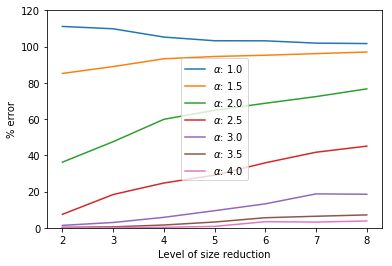

In [125]:
plotRandomisedSizeReducedMatrixProduct()

In [126]:
_ = gc.collect()

## Real-World Applications: Phenology

The following section will apply the same techniques to real datasets. In this section, we will examine the extended spring indices and the AVHRR start of season phenometric.

### Dataset Preperation

The following functions are used to plot the fields, taking into account their original 3D shape.

In [127]:
def structureMatrix(dataVector, maskFlattened, maskShape):
    structuredMatrix = numpy.full(maskShape[0] * maskShape[1], numpy.nan, dtype=numpy.float64)
    structuredMatrix[maskFlattened] = dataVector
    structuredMatrix = structuredMatrix.reshape(maskShape)
    return structuredMatrix

In [128]:
def structureMatrix3D(dataVectors, maskFlattened, maskShape):
    return numpy.array([structureMatrix(spatial, maskFlattened, maskShape) for spatial in dataVectors.swapaxes(0,1)]).swapaxes(0,2).swapaxes(0,1)

In [129]:
def plotStructuredMatrix(structuredMatrix, filePath = None):
    matplotlib.pyplot.imshow(structuredMatrix, aspect="auto")
    matplotlib.pyplot.colorbar()
    if filePath is not None:
        matplotlib.pyplot.savefig(filePath)
    matplotlib.pyplot.show()

In [130]:
def plotMatrix(dataVector, maskFlattened, maskShape, filePath = None):
    structuredMatrix = structureMatrix(dataVector, maskFlattened, maskShape)
    plotStructuredMatrix(structuredMatrix, filePath)

We load the data from compressed numpy files. This includes a mask which describes the boundary of the USA. The value of the fields over the ocean is NaN.

In [131]:
maskFlattened = numpy.load("Data/Mask.npz")["maskFlattened"]
maskShape = numpy.load("Data/Mask.npz")["maskShape"]

In [132]:
dataSetBloom = numpy.load("Data/Bloom.npz")["dataSetBloom"]

In [133]:
dataSetSos = numpy.load("Data/Sos.npz")["dataSetSos"]

In [134]:
dataSetBloomFiltered = dataSetBloom[maskFlattened]

In [135]:
dataSetSosFiltered = dataSetSos[maskFlattened]

The datasets include some missing values, even over the land surface. We will not spend time imputing these in a fancy way, but simply add some reasonable random values. For the cross-correlation analysis, we need to scale the datasets.

In [136]:
meanBloom = numpy.nanmean(dataSetBloomFiltered)
stdBloom = numpy.nanstd(dataSetBloomFiltered)
nansBloom = numpy.isnan(dataSetBloomFiltered)
numberOfNaNsBloom = numpy.count_nonzero(nansBloom)
imputedValuesBloom = numpy.random.normal(meanBloom, stdBloom, numberOfNaNsBloom)
dataSetBloomImputed = numpy.copy(dataSetBloomFiltered)
dataSetBloomImputed[nansBloom] = imputedValuesBloom

In [137]:
meanSos = numpy.nanmean(dataSetSosFiltered)
stdSos = numpy.nanstd(dataSetSosFiltered)
nansSos = numpy.isnan(dataSetSosFiltered)
numberOfNaNsSos = numpy.count_nonzero(nansSos)
imputedValuesSos = numpy.random.normal(meanSos, stdSos, numberOfNaNsSos)
dataSetSosImputed = numpy.copy(dataSetSosFiltered)
dataSetSosImputed[nansSos] = imputedValuesSos

In [138]:
dataSetBloomScaled = centerAndStandardiseField(dataSetBloomImputed)

In [139]:
dataSetSosScaled = centerAndStandardiseField(dataSetSosImputed)

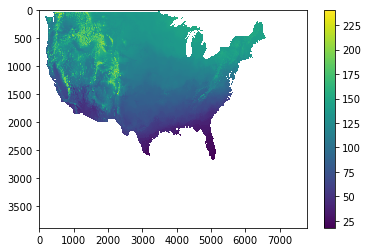

In [140]:
plotMatrix(dataSetBloomImputed[:, 0], maskFlattened, maskShape)

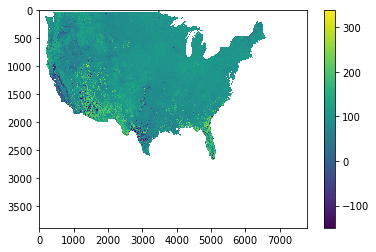

In [141]:
plotMatrix(dataSetSosImputed[:, 0], maskFlattened, maskShape)

In order to run our techniques for single fields (so without the time component), let's take the first time period. Let's also zoom in on a patch of the USA which is square and which does not include any missing values from the ocean areas. Although it won't give a precise measure, this patch will also be used to estimate the level of autocorrelation in the data.

In [142]:
structuredMatrixBloom = structureMatrix(dataSetBloomImputed[:, 0], maskFlattened, maskShape)
squareSubMatrixBloom = structuredMatrixBloom[900:1900, 1500:2500]

In [143]:
structuredMatrixSos = structureMatrix(dataSetSosImputed[:, 0], maskFlattened, maskShape)
squareSubMatrixSos = structuredMatrixSos[900:1900, 1500:2500]

Estimated Alpha: 2.755 | r^2: 0.530
Estimated Beta: 3.572 | r^2: 0.875
Moran's I: 0.970


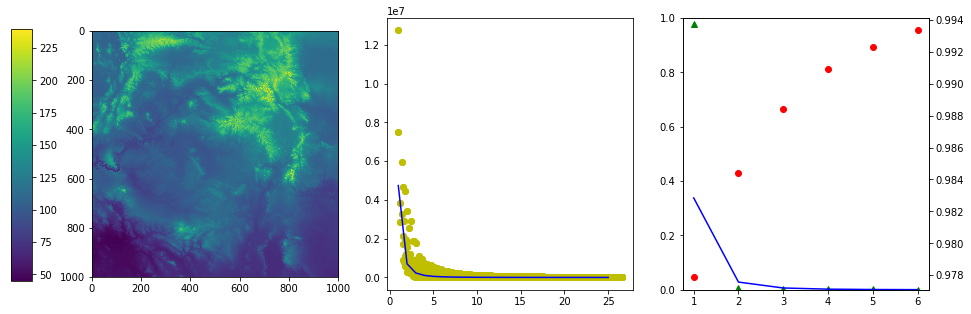

In [144]:
data = squareSubMatrixBloom
size = 1000
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(numpy.max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(numpy.max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

Estimated Alpha: 1.213 | r^2: 0.185
Estimated Beta: 1.612 | r^2: 0.750
Moran's I: 0.371


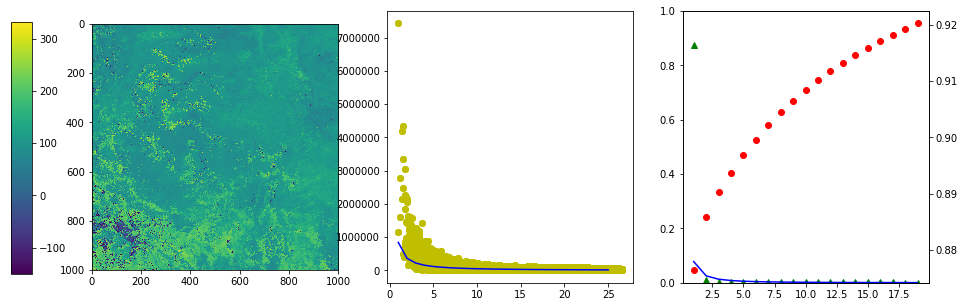

In [145]:
data = squareSubMatrixSos
size = 1000
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(numpy.max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(numpy.max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

In [146]:
_ = gc.collect()

### Efficient SVD via Spatial Coarsening

In this section, the single time period will be coarsened and decomposed.

#### Single Spatial Field via Spatial Coarsening

The following function takes the input matrix, coarsens it and compares the SVD results.

In [147]:
def calculateSingleSpatialFieldViaCoarsening(matrix, level=4, modes=4):
    coarsenedMatrix = coarsenMatrix(matrix, level)
    coarsenedMatrixReduced = reduceMatrix(coarsenedMatrix, modes)
    uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrixReduced, level)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(uncoarsenedMatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

The Bloom extended Spring Index showed very high levels of autocorrelation. Our analysis of coarsening applied to _Gaussian Random Fields_ showed that autocorrelations between $2$ and $3$ resulted in errors between 3% and 15%. In fact, the performance here seems to be substantially better than that.

In [148]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom)

0.006109500646129436

As before, changing the level of coarsening affects the performance.

In [149]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, level=2)

0.002978478120548883

In [150]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, level=8)

0.011483692748974358

Also the number of modes of interest affects how large the error is.

In [151]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, modes=2)

0.004444908432042166

In [152]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, modes=8)

0.00863672323421509

Compared with the Bloom data, the Start-of-Season field has quite low autocorrelation. Based on the plot and on the $R^2$, we can see that the estimation of $\alpha$ is not very accurate. Perhaps Moran's $I$ gives a better indication of the level of autocorrelation. Either way, the amount of error due to coarsening is higher than for the Bloom data, but still not very substantial.

In [153]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos)

0.03912231728700376

As before, changing the level of coarsening affects the performance.

In [154]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, level=2)

0.026077963511414528

In [155]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, level=8)

0.06349824159829501

Also the number of modes of interest affects how large the error is.

In [156]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, modes=2)

0.02504791766930838

In [157]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, modes=8)

0.05379313477952314

In [158]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

The following functions coarsen the input matrices, perform an SVD on their cross-correlation matrix and compare the results.

In [159]:
def uncoarsenMatrix3D(array, level):
    h, w, d = array.shape
    uncoarsenedMatrix3D = numpy.empty((h * level, w * level, d))
    for i in range(d):
        uncoarsenedMatrix3D[:, :, i] = uncoarsenMatrix(array[:, :, i], level)
    return uncoarsenedMatrix3D

In [160]:
def calculateProductSpatialTemporalFieldsViaCoarseningWithMask(matrixScaled1, matrixScaled2, maskFlattened, maskShape, level=4, modes=8):
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, modes)
    maskStructured = structureMatrix(maskFlattened[maskFlattened], maskFlattened, maskShape)
    maskCoarsened = ~numpy.isnan(coarsenMatrix(maskStructured, level)).flatten()
    matrixCoarsened1 = coarsenMatrix3D(structureMatrix3D(matrixScaled1, maskFlattened, maskShape), level)
    matrixCoarsened2 = coarsenMatrix3D(structureMatrix3D(matrixScaled2, maskFlattened, maskShape), level)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixCoarsened1, matrixCoarsened2)
    matrixMasked1 = matrixFlattened1[maskCoarsened]
    matrixMasked2 = matrixFlattened2[maskCoarsened]
    U2, s2, Vt2 = qrProductSVD(matrixMasked1, matrixMasked2)
    U2Restructured = structureMatrix3D(U2, maskCoarsened, (maskShape[0] // level, maskShape[1] // level))
    U2Uncoarsened = uncoarsenMatrix3D(U2Restructured, level)
    U2Uncoarsened = U2Uncoarsened.reshape(maskShape[0] * maskShape[1], U2Restructured.shape[2])[maskFlattened] / level
    V2Restructured = structureMatrix3D(Vt2.T, maskCoarsened, (maskShape[0] // level, maskShape[1] // level))
    V2Uncoarsened = uncoarsenMatrix3D(V2Restructured, level)
    V2Uncoarsened = V2Uncoarsened.reshape(maskShape[0] * maskShape[1], U2Restructured.shape[2])[maskFlattened] / level
    s2Uncoarsened = s2 * level**2
    U2, s2, Vt2 = reduceUSV(U2Uncoarsened, s2Uncoarsened, V2Uncoarsened.T, modes)
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

The analysis on coarsened spatio-temporal fields showed that autocorrelations between $2$ and $3$ resulted in errors between 20% and 80%. Although this is not a very precise prediction, the current datasets seem to conform to it.

In [161]:
calculateProductSpatialTemporalFieldsViaCoarseningWithMask(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=4, modes=8)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


0.5271908495049115

In [162]:
_ = gc.collect()

Unfortunately, even with a low level of coarsening, the results are not great. Though they conform to our predictions.

In [163]:
calculateProductSpatialTemporalFieldsViaCoarseningWithMask(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=2, modes=8)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


0.42921750033363576

In [164]:
_ = gc.collect()

The number of modes of interest does not have a large effect.

In [165]:
calculateProductSpatialTemporalFieldsViaCoarseningWithMask(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=4, modes=4)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


0.5066051907340412

In [166]:
_ = gc.collect()

### Efficient SVD via Randomised Dimensionality Reduction

In this section, the single time period will be decomposed using the random algorithm.

#### Single Spatial Field via Randomised Dimensionality Reduction

The _calculateRandomisedSizeReducedMatrix_ function takes a matrix, performs the decomposition and compares the result.

In [167]:
def calculateRandomisedSizeReducedMatrix(matrix, level=4, i=1, modes=8):
    H, L, W = reduceSizeRandomisedSquare(matrix, i, matrix.shape[0] // level)
    LReduced = reduceMatrix(L, modes)
    reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, LReduced, W)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(reconstructedmatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

As expected from our previous analyses, the error is negligible.

In [168]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom)

1.0610129992300191e-06

Changing the level of reduction affects the error somewhat, though it remains small.

In [169]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, level=2)

5.7296414485035966e-08

In [170]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, level=8)

1.0061163054877638e-05

The number of iterations in our random algorithm does have a substantial effect.

In [171]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, i=0)

0.0027031912681364997

In [172]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, i=2)

7.575617896677583e-10

The number of modes on interest has little effect.

In [173]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, modes=4)

2.4054096880396214e-07

In [174]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, modes=16)

5.362241009156597e-06

The Start-of-season data has less autocorrelation and the results are slightly worse.

In [175]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos)

0.0009005225805638633

Again, some effect of the level of reduction.

In [176]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, level=2)

9.016964473481065e-05

In [177]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, level=8)

0.0035366380772093803

The effect of the number of iterations is quite large.

In [178]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, i=0)

0.034307772202685306

In [179]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, i=2)

3.082476536595658e-05

The number of modes of interest has little effect.

In [180]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, modes=4)

0.0004140405768728846

In [181]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, modes=16)

0.0022026679713494325

Let's collect garbage to keep our _Jupyter Notebook_ running smoothly.

In [182]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

In this section, we will reduce two datasets, perform an SVD on their cross-correlation matrix and then compare the results.

In [183]:
def calculateRandomisedSizeReducedMatrixProduct(matrixScaled1, matrixScaled2, level=4, i=2, modes=8):
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, min(modes, int(temporalSize / level)))
    U2, s2, Vt2 = randomisedSquareProductSVD(matrixScaled1, matrixScaled2, i, int(temporalSize / level))
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, min(modes, int(temporalSize / level)))
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

For datasets with an $\alpha$ between $2$ and $3$, our previous analysis shows that we can expect an error between 0% and 60%. Although this prediction is not very precise, the Bloom and Start-of-season data fall nicely in the middle of the range. Note that with a level equal to $4$, the data on which the SVD is performed in $16$ times smaller than the original.

In [184]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled)

0.29926320847287885

In [185]:
_ = gc.collect()

Our previous analysis suggests a reduction level equal to $3$ should give errors between 5% and 40%, while a reduction level of $8$ gives errors between 20% and 100%. Our datasets fall in the middle of this range.

In [186]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, level=3)

0.2076543138392269

In [187]:
_ = gc.collect()

In [188]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, level=8)

0.46938185144260275

In [189]:
_ = gc.collect()

Having fewer iterations worsens the result, while more iterations do not seem to help.

In [190]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, i=0)

0.5625355203378106

In [191]:
_ = gc.collect()

In [192]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, i=4)

0.29520575859776593

In [193]:
_ = gc.collect()

The effect of the modes is small.

In [194]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, modes=4)

0.2754205145462697

In [195]:
_ = gc.collect()

In [196]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, modes=16)

0.35137626957784457

In [197]:
_ = gc.collect()

## Real-World Applications: JRA-55

The following section will apply our dataset reduction techniques to global atmospheric energy data from JRA-55 [17, 18].

### Dataset Preperation

Let's first load the data and standardize each gridpoints' timeseries.

In [198]:
energyArray = numpy.load("Data/JRA55.npz")["energyArray"]

In [199]:
latentHeatArray = numpy.load("Data/JRA55.npz")["latentHeatArray"]

In [200]:
energyArrayScaled = centerAndStandardiseSpatioTemporalField(energyArray)

In [201]:
latentHeatArrayScaled = centerAndStandardiseSpatioTemporalField(latentHeatArray)

In [202]:
energyArrayFlattened, latentHeatArrayFlattened = flattenSpatialTemporalFields(energyArrayScaled, latentHeatArrayScaled)

By taking the first time period, we can get an impression of the spatial autocorrelation within the fields. The estimations of $\alpha$ do not seem to be reliable, but Moran's $I$ suggests fairly high levels of autocorrelation.

Estimated Alpha: 5.486 | r^2: 0.575
Estimated Beta: 2.488 | r^2: 0.908
Moran's I: 0.932


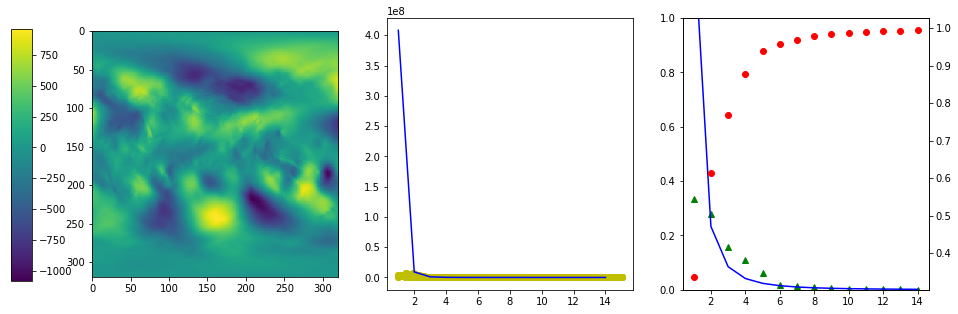

In [203]:
data = energyArray[:320, :320, 0]
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

Estimated Alpha: 5.553 | r^2: 0.679
Estimated Beta: 2.276 | r^2: 0.975
Moran's I: 0.859


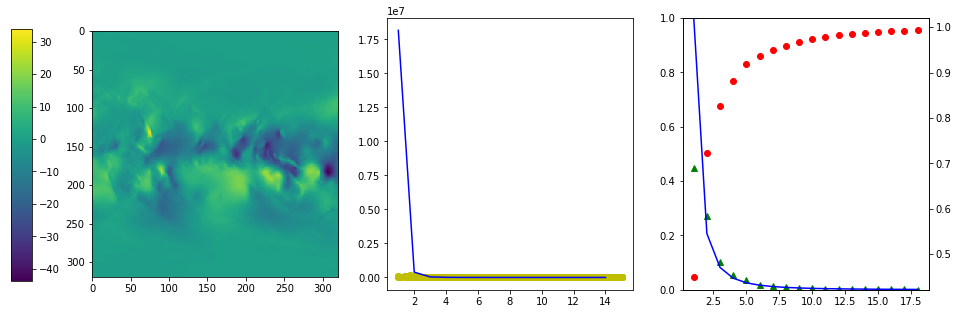

In [204]:
data = latentHeatArray[:320, :320, 0]
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

### Efficient SVD via Spatial Coarsening

In this section, the single time period will be coarsened and decomposed.

#### Single Spatial Field via Spatial Coarsening

The JRA-55 energy array showed high levels of autocorrelation. Our analysis of coarsening applied to _Gaussian Random Fields_ suggests that autocorrelations around $\alpha=3$ result in errors around 5%. This prediction seems to be accurate.

In [205]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0])

0.07729416922772912

Coarsening at a level equal to $2$ would bring the error down to a few percent, while a level equal to $8$ would bring it closer to 10%. The JRA-55 energy data seem to behave according to this prediction.

In [206]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0], level=2)

0.034540226790190205

In [207]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0], level=8)

0.15829677910918

Changing the modes of interest has little effect.

In [208]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0], modes=2)

0.07052296565826134

In [209]:
calculateSingleSpatialFieldViaCoarsening(energyArray[:,:,0], modes=8)

0.08484182874891781

For _Gaussian Random Fields_ with an $\alpha=2.5$, our analysis predicts an error of around 10% after coarsening. The JRA-55 latent heat data seem to behave according to this prediction.

In [210]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0])

0.10623778724098142

For coarsening levels of $2$ and $8$, the prediction ranges from 3% to 15%. The current dataset, although slightly higher, conforms largely to this prediction.

In [211]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0], level=2)

0.048168427936774214

In [212]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0], level=8)

0.20988418220816127

Again, the number of modes only has a minor effect. 

In [213]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0], modes=2)

0.09344129267113191

In [214]:
calculateSingleSpatialFieldViaCoarsening(latentHeatArray[:,:,0], modes=8)

0.12043129312429646

In [215]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

The following function coarsens the input matrices, performs an SVD on their cross-correlation matrix and compares the results.

In [216]:
def calculateProductSpatialTemporalFieldsViaCoarsening(matrix1, matrix2, level=4, modes=8):
    h, w, d = matrix1.shape
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrix1, matrix2)
    U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U1, s1, Vt1 = reduceUSV(U1, s1, Vt1, modes)
    matrixCoarsened1 = coarsenMatrix3D(matrix1, level)
    matrixCoarsened2 = coarsenMatrix3D(matrix2, level)
    matrixCoarsenedFlattened1, matrixCoarsenedFlattened2 = flattenSpatialTemporalFields(matrixCoarsened1, matrixCoarsened2)
    U2, s2, Vt2 = qrProductSVD(matrixCoarsenedFlattened1, matrixCoarsenedFlattened2)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, modes)
    U2, s2, Vt2 = uncoarsenUSV(U2, s2, Vt2, level, w // level)
    return percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)

The analysis on coarsened spatio-temporal fields showed that autocorrelations between $2.5$ and $3$ resulted in errors between 40% and 70%. Although this is not a very precise prediction, the current datasets clearly falls below this range. Perhaps _Gaussian Random Fields_ are not good representations of the JRA-55 datasets or there are other effects not taken into account by our method.

In [217]:
calculateProductSpatialTemporalFieldsViaCoarsening(energyArrayScaled, latentHeatArrayScaled, level=4, modes=8)

0.15571092821198168

In [218]:
_ = gc.collect()

As before, decreasing the level improves the results.

In [219]:
calculateProductSpatialTemporalFieldsViaCoarsening(energyArrayScaled, latentHeatArrayScaled, level=2, modes=8)

0.0794196808600399

In [220]:
_ = gc.collect()

Having fewer modes does not affect the results substantially.

In [221]:
calculateProductSpatialTemporalFieldsViaCoarsening(energyArrayScaled, latentHeatArrayScaled, level=4, modes=4)

0.15943781506863378

In [222]:
_ = gc.collect()

### Efficient SVD via Randomised Dimensionality Reduction

In this section, the single time period will be decomposed using the random algorithm.

#### Single Spatial Field via Randomised Dimensionality Reduction

As expected from our previous analyses, the error is negligible.

In [223]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0])

6.364773857337255e-07

Changing the level of reduction affects the error somewhat, though it remains small.

In [224]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], level=2)

1.0161660015938532e-08

In [225]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], level=8)

1.8880376928308636e-05

The number of iterations in our random algorithm does have a substantial effect.

In [226]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], i=0)

0.006568877017824018

In [227]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], i=2)

1.667774830405795e-10

The number of modes of interest has little effect.

In [228]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], modes=4)

7.852478471540505e-08

In [229]:
calculateRandomisedSizeReducedMatrix(energyArray[:,:,0], modes=16)

9.004878325271418e-06

The JRA-55 latent heat data has less autocorrelation and the results are slightly worse.

In [230]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0])

2.033770339762554e-06

Again, some effect of the level of reduction.

In [231]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], level=2)

1.2497895647912187e-08

In [232]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], level=8)

9.328120912327878e-05

The effect of the number of iterations is quite large.

In [233]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], i=0)

0.008144178640411797

In [234]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], i=2)

6.071092428045955e-10

The number of modes of interest has some, but only little effect.

In [235]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], modes=4)

2.925403981561921e-07

In [236]:
calculateRandomisedSizeReducedMatrix(latentHeatArray[:,:,0], modes=16)

1.7473737327678588e-05

Let's collect garbage to keep our _Jupyter Notebook_ running smoothly.

In [237]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

In this section, we will reduce two datasets, perform an SVD on their cross-correlation matrix and then compare the results.

For datasets with an $\alpha$ between $2.5$ and $3$, our previous analysis shows that we can expect an error between 5% and 25%. Although this prediction is not very precise, the JRA-55 data fall nicely in the range.

In [238]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened)

0.19214394819003916

In [239]:
_ = gc.collect()

Our previous analysis suggests a reduction level equal to $3$ should give errors between 3% and 20%, while a reduction level of $8$ gives errors between 10% and 80%. Our datasets fall in the middle of this range.

In [240]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, level=3)

0.1302813180366193

In [241]:
_ = gc.collect()

In [242]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, level=8)

0.32712885802919306

In [243]:
_ = gc.collect()

Having fewer iterations worsens the result substantially, while more iterations helps slightly.

In [244]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, i=0)

0.671457663854648

In [245]:
_ = gc.collect()

In [246]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, i=4)

0.142485483244197

In [247]:
_ = gc.collect()

The effect of the modes is quite substantial in this case.

In [248]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, modes=4)

0.12242428138281368

In [249]:
_ = gc.collect()

In [250]:
calculateRandomisedSizeReducedMatrixProduct(energyArrayFlattened, latentHeatArrayFlattened, modes=16)

0.255936528754878

In [251]:
_ = gc.collect()

## Real-World Applications: ERA-5

The following section will apply the same techniques to global cloud an humidty data from ERA-5 [ref].

### Dataset Preperation

Text

In [252]:
humidityArray = numpy.load("Data/ERA5.npz")["humidityArray"][:720,:720,:]

In [253]:
cloudCoverArray = numpy.load("Data/ERA5.npz")["cloudCoverArray"][:720,:720,:]

In [254]:
humidityArrayScaled = centerAndStandardiseSpatioTemporalField(humidityArray)

In [255]:
cloudCoverArrayScaled = centerAndStandardiseSpatioTemporalField(cloudCoverArray)

In [256]:
humidityArrayFlattened, cloudCoverArrayFlattened = flattenSpatialTemporalFields(humidityArrayScaled, cloudCoverArrayScaled)

Text

Estimated Alpha: 6.888 | r^2: 0.732
Estimated Beta: 2.737 | r^2: 0.929
Moran's I: 0.985


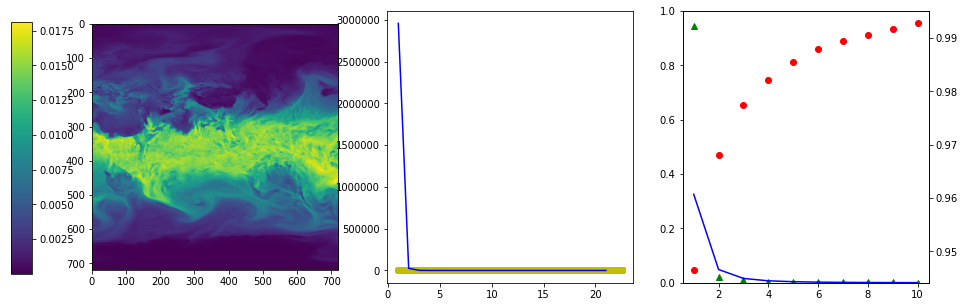

In [257]:
data = humidityArray[:,:,0]
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

Estimated Alpha: 5.730 | r^2: 0.732
Estimated Beta: 1.555 | r^2: 0.986
Moran's I: 0.821


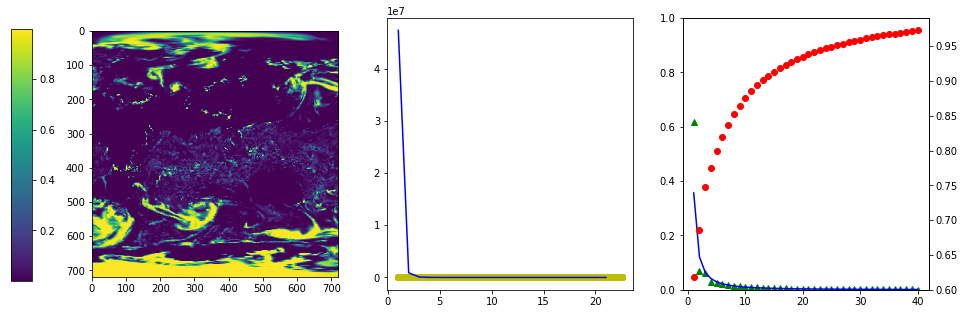

In [258]:
data = cloudCoverArray[:,:,0]
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
mi = approximateMoransI(data, bandwidth=10)
print("Moran's I: {:0.3f}".format(mi))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked, fftMasked, "yo")
ax2.plot(range(1, int(max(wavesMasked))), math.exp(estimatedIntercept) * numpy.power(range(1, int(max(wavesMasked))), -estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, -estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

### Efficient SVD via Spatial Coarsening

Text

#### Single Spatial Field via Spatial Coarsening

Text

In [259]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0])

0.016620680289435797

Text

In [260]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0], level=2)

0.007608078642445399

In [261]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0], level=8)

0.03221603083762712

Text

In [262]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0], modes=2)

0.014014747691768498

In [263]:
calculateSingleSpatialFieldViaCoarsening(humidityArray[:,:,0], modes=8)

0.02067543902065631

Text

In [264]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0])

0.07835479799668128

Text

In [265]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0], level=2)

0.0372777911253177

In [266]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0], level=8)

0.14017472688434182

Text

In [267]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0], modes=2)

0.06217610991408565

In [268]:
calculateSingleSpatialFieldViaCoarsening(cloudCoverArray[:,:,0], modes=8)

0.09930190899630693

In [269]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Spatial Coarsening

Text

In [270]:
calculateProductSpatialTemporalFieldsViaCoarsening(humidityArrayScaled, cloudCoverArrayScaled, level=4, modes=8)

0.29977351253935586

In [271]:
_ = gc.collect()

Text

In [272]:
calculateProductSpatialTemporalFieldsViaCoarsening(humidityArrayScaled, cloudCoverArrayScaled, level=2, modes=8)

0.16604652019942928

In [273]:
_ = gc.collect()

Text

In [274]:
calculateProductSpatialTemporalFieldsViaCoarsening(humidityArrayScaled, cloudCoverArrayScaled, level=4, modes=4)

0.2844144758899671

In [275]:
_ = gc.collect()

### Efficient SVD via Randomised Dimensionality Reduction

Text

#### Single Spatial Field via Randomised Dimensionality Reduction

Text

In [276]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0])

3.25623039075315e-08

Text

In [277]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], level=2)

4.360059708541074e-15

In [278]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], level=8)

6.820991213629875e-06

Text

In [279]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], i=0)

0.0007974243742152436

In [280]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], i=2)

1.6189885450342483e-12

Text

In [281]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], modes=4)

5.9151450760217425e-09

In [282]:
calculateRandomisedSizeReducedMatrix(humidityArray[:,:,0], modes=16)

1.364249043889837e-07

Text

In [283]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0])

6.1720008563248745e-06

Text

In [284]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], level=2)

1.0501523662208396e-09

In [285]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], level=8)

0.00027671155468980837

Text

In [286]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], i=0)

0.011129549015428822

In [287]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], i=2)

4.583555587892983e-09

Text

In [288]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], modes=4)

2.002821652217482e-06

In [289]:
calculateRandomisedSizeReducedMatrix(cloudCoverArray[:,:,0], modes=16)

1.9306324701029073e-05

Text

In [290]:
_ = gc.collect()

#### Product of Spatio-Temporal Fields via Randomised Dimensionality Reduction

Text

In [291]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened)

0.1453716409396258

In [292]:
_ = gc.collect()

Text

In [293]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, level=3)

0.08390339786624137

In [294]:
_ = gc.collect()

In [295]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, level=8)

0.3895457971629304

In [296]:
_ = gc.collect()

Text

In [297]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, i=0)

0.675807560515678

In [298]:
_ = gc.collect()

In [299]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, i=4)

0.08734973831127098

In [300]:
_ = gc.collect()

Text

In [301]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, modes=4)

0.091638983523614

In [302]:
_ = gc.collect()

In [303]:
calculateRandomisedSizeReducedMatrixProduct(humidityArrayFlattened, cloudCoverArrayFlattened, modes=16)

0.237294848502292

In [304]:
_ = gc.collect()

## Unsuccessful Techniques

The following techniques related to SVD's were investigated but did not provide clear results. These sections are not documented well because they were not included in the final article [3].

### Noise Reduction via Pre-Filtering

The reduction of the number of dimensions of each input dataset is actually advised by some researchers, as a method to filter out noise [1]. Especially  when  the  number of temporal samples is small, outliers and random fluctuations could affect the result [4]. This is because any statistical analysis will choose its regression-coefficients so as to optimize the fit. It may occur that two noise-vectors in the two fields coincidentally covary and show up as dominant modes. Prefiltering can alleviate this risk.

#### Single Spatial Field

Text

In [305]:
def addNoise(matrix, noiseLevel=1.0):
    return matrix + numpy.random.normal(loc=0.0, scale=noiseLevel, size=matrix.shape)

Text

In [306]:
def testNoiseReduction(size=200, alpha=2, noiseScale=0.1, reduction=3):
    matrix = gaussianRandomSpatialField(alpha, size)
    noiseLevel = noiseScale * numpy.std(matrix)
    matrixNoise = addNoise(matrix, noiseLevel)
    matrixNoiseReduced = reduceMatrix(matrixNoise, size//reduction)
    normMatrix = scipy.linalg.norm(matrix)
    normDifferenceMatrixNoise = scipy.linalg.norm(matrix - matrixNoise)
    normDifferenceMatrixNoiseReduced = scipy.linalg.norm(matrix - matrixNoiseReduced)
    percentageNormDifference1 = normDifferenceMatrixNoise / normMatrix
    percentageNormDifference2 = normDifferenceMatrixNoiseReduced / normMatrix
    percentageNormDifference3 = normDifferenceMatrixNoiseReduced / normDifferenceMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [307]:
loop(testNoiseReduction)

array([0.10000958, 0.26469476, 2.64665885])

In [308]:
loop(testNoiseReduction, {"size": 100})

array([0.10015361, 0.27585855, 2.75382671])

In [309]:
loop(testNoiseReduction, {"size": 400})

array([0.10001803, 0.23984225, 2.39792136])

In [310]:
loop(testNoiseReduction, {"alpha": 1})

array([0.09999925, 0.46870146, 4.68714702])

In [311]:
loop(testNoiseReduction, {"alpha": 4})

array([0.10022866, 0.08560777, 0.85411902])

In [312]:
loop(testNoiseReduction, {"noiseScale": 0.05})

array([0.04990266, 0.2505554 , 5.02083826])

In [313]:
loop(testNoiseReduction, {"noiseScale": 0.5})

array([0.50015307, 0.48629231, 0.97228654])

In [314]:
loop(testNoiseReduction, {"reduction": 2})

array([0.09977266, 0.17202555, 1.72415692])

In [315]:
loop(testNoiseReduction, {"reduction": 4})

array([0.09998879, 0.31447327, 3.14504936])

#### Product of Spatial Fields

Text

In [316]:
def testNoiseReductionProduct(size=200, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, size, 2)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrix1 = matrixCombined[:, :, 0]
    matrix2 = matrixCombined[:, :, 1]
    productMatrix = matrix1 @ matrix2.T
    productMatrixReconstructed = reduceMatrix(productMatrix, size//reconstruction)
    matrixNoise1 = addNoise(matrix1, noiseLevel)
    matrixNoise2 = addNoise(matrix2, noiseLevel)
    productMatrixNoise = matrixNoise1 @ matrixNoise2.T
    productMatrixNoiseReconstructed = reduceMatrix(productMatrixNoise, size//reconstruction)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, size//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, size//reduction)
    productMatrixNoiseReduced = matrixNoiseReduced1 @ matrixNoiseReduced2.T    
    productMatrixNoiseReducedReconstructed = reduceMatrix(productMatrixNoiseReduced, size//reconstruction)
    normProductMatrix = scipy.linalg.norm(productMatrixReconstructed)
    normDifferenceProductMatrixNoise = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReconstructed)
    normDifferenceProductMatrixNoiseReduced = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReducedReconstructed)
    percentageNormDifference1 = normDifferenceProductMatrixNoise / normProductMatrix
    percentageNormDifference2 = normDifferenceProductMatrixNoiseReduced / normProductMatrix
    percentageNormDifference3 = normDifferenceProductMatrixNoiseReduced / normDifferenceProductMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [317]:
loop(testNoiseReductionProduct)

array([0.0562723 , 0.10010857, 1.77541304])

In [318]:
loop(testNoiseReductionProduct, {"size": 100})

array([0.06721828, 0.12621914, 1.87215201])

In [319]:
loop(testNoiseReductionProduct, {"size": 400})

array([0.04644324, 0.07482573, 1.60486751])

In [320]:
loop(testNoiseReductionProduct, {"alpha": 1})

array([0.15828324, 0.44538225, 2.82390335])

In [321]:
loop(testNoiseReductionProduct, {"alpha": 4})

array([0.01848102, 0.01847637, 1.00014549])

In [322]:
loop(testNoiseReductionProduct, {"noiseScale": 0.05})

array([0.02765237, 0.08365539, 3.0207734 ])

In [323]:
loop(testNoiseReductionProduct, {"noiseScale": 0.5})

array([0.27614351, 0.2759647 , 0.99844448])

In [324]:
loop(testNoiseReductionProduct, {"reduction": 2})

array([0.05142742, 0.06434711, 1.24937012])

In [325]:
loop(testNoiseReductionProduct, {"reduction": 4})

array([0.05411719, 0.11840412, 2.17951349])

In [326]:
loop(testNoiseReductionProduct, {"reconstruction": 3})

array([0.05522529, 0.09865823, 1.78401191])

In [327]:
loop(testNoiseReductionProduct, {"reconstruction": 5})

array([0.05213905, 0.08797603, 1.68337004])

#### Product of Spatial Fields with Correlated Noise

Text

In [328]:
def addCorrelatedNoise3D(matrix, noiseLevel=1.0):
    noise = noiseLevel * gaussianRandomSpatialTemporalField(alpha/4, matrix.shape[0], matrix.shape[2])  
    return matrix + noise

Text

In [329]:
def testNoiseReductionCorrelatedNoiseProduct(size=200, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, size, 2)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrix1, matrix2 = splitSpatialTemporalField(matrixCombined)
    matrixNoise1, matrixNoise2 = splitSpatialTemporalField(matrixCombinedNoise)
    productMatrix = matrix1[:, :, 0] @ matrix2[:, :, 0].T
    productMatrixReconstructed = reduceMatrix(productMatrix, size//reconstruction)
    productMatrixNoise = matrixNoise1[:, :, 0] @ matrixNoise2[:, :, 0].T
    productMatrixNoiseReconstructed = reduceMatrix(productMatrixNoise, size//reconstruction)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1[:, :, 0], size//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2[:, :, 0], size//reduction)
    productMatrixNoiseReduced = matrixNoiseReduced1 @ matrixNoiseReduced2.T    
    productMatrixNoiseReducedReconstructed = reduceMatrix(productMatrixNoiseReduced, size//reconstruction)
    normProductMatrix = scipy.linalg.norm(productMatrixReconstructed)
    normDifferenceProductMatrixNoise = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReconstructed)
    normDifferenceProductMatrixNoiseReduced = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReducedReconstructed)
    percentageNormDifference1 = normDifferenceProductMatrixNoise / normProductMatrix
    percentageNormDifference2 = normDifferenceProductMatrixNoiseReduced / normProductMatrix
    percentageNormDifference3 = normDifferenceProductMatrixNoiseReduced / normDifferenceProductMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [330]:
loop(testNoiseReductionCorrelatedNoiseProduct)

array([0.07601703, 0.10479602, 1.37418871])

In [331]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"size": 100})

array([0.09179048, 0.14111621, 1.53093456])

In [332]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"size": 400})

array([0.06159383, 0.07907228, 1.28397977])

In [333]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"alpha": 1})

array([0.17711335, 0.45493266, 2.57538537])

In [334]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"alpha": 4})

array([0.0337363 , 0.03374193, 1.00021961])

In [335]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"noiseScale": 0.05})

array([0.04114528, 0.09451633, 2.29040099])

In [336]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"noiseScale": 0.5})

array([0.39774221, 0.39737807, 0.99907538])

In [337]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reduction": 2})

array([0.0798463 , 0.09047578, 1.13265072])

In [338]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reduction": 4})

array([0.07568759, 0.12519162, 1.64703277])

In [339]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reconstruction": 3})

array([0.07746583, 0.11323745, 1.45906136])

In [340]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reconstruction": 5})

array([0.07880502, 0.10880114, 1.38013719])

#### Product of Spatio-Temporal Fields with Correlated Noise

Text

In [341]:
def testNoiseReductionSpatialTemporalField(spatialSize=100, temporalSize=60, alpha=2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    matrixNoise1, matrixNoise2 = splitAndFlattenSpatialTemporalField(matrixCombinedNoise)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, temporalSize//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, temporalSize//reduction)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    UNoise, sNoise, VtNoise = qrProductSVD(matrixNoise1, matrixNoise2)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = qrProductSVD(matrixNoiseReduced1, matrixNoiseReduced2)
    U, s, Vt = reduceUSV(U, s, Vt, temporalSize//reconstruction)
    UNoise, sNoise, VtNoise = reduceUSV(UNoise, sNoise, VtNoise, temporalSize//reconstruction)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = reduceUSV(UNoiseReduced, sNoiseReduced, VtNoiseReduced, temporalSize//reconstruction)
    percentageNormDifference1 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoise, sNoise, VtNoise)
    percentageNormDifference2 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    percentageNormDifference3 = percentageNormDifferenceFromUSVs(UNoise, sNoise, VtNoise, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [342]:
loop(testNoiseReductionSpatialTemporalField)

array([0.11937219, 0.21774885, 0.18426351])

In [343]:
loop(testNoiseReductionSpatialTemporalField, {"temporalSize": 20})

array([0.12968009, 0.29801793, 0.27166317])

In [344]:
loop(testNoiseReductionSpatialTemporalField, {"temporalSize": 100})

array([0.11188041, 0.14499434, 0.09162783])

In [345]:
loop(testNoiseReductionSpatialTemporalField, {"alpha": 1})

array([0.25098305, 0.60948389, 0.59058123])

In [346]:
loop(testNoiseReductionSpatialTemporalField, {"alpha": 4})

array([0.03405053, 0.03407432, 0.00144902])

In [347]:
loop(testNoiseReductionSpatialTemporalField, {"noiseScale": 0.05})

array([0.05868219, 0.16861867, 0.15946564])

In [348]:
loop(testNoiseReductionSpatialTemporalField, {"noiseScale": 0.5})

array([0.61721177, 0.62751344, 0.23701001])

In [349]:
loop(testNoiseReductionSpatialTemporalField, {"reduction": 2})

array([0.12397504, 0.16062724, 0.11649363])

In [350]:
loop(testNoiseReductionSpatialTemporalField, {"reduction": 4})

array([0.12076687, 0.21185114, 0.17843848])

In [351]:
loop(testNoiseReductionSpatialTemporalField, {"reconstruction": 3})

array([0.12447213, 0.22190897, 0.18982577])

In [352]:
loop(testNoiseReductionSpatialTemporalField, {"reconstruction": 5})

array([0.11639455, 0.17011979, 0.1312659 ])

#### Product of Standardised Spatio-Temporal Fields with Correlated Noise

Text

In [353]:
def testNoiseReductionSpatialTemporalFieldCorrelation(spatialSize=100, temporalSize=60, alpha=2, noiseScale=0.1, reduction=3, reconstruction=5):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    matrixScaled1 = centerAndStandardiseField(matrixFlattened1)
    matrixScaled2 = centerAndStandardiseField(matrixFlattened2)
    matrixNoise1, matrixNoise2 = splitAndFlattenSpatialTemporalField(matrixCombinedNoise)
    matrixNoiseScaled1 = centerAndStandardiseField(matrixNoise1)
    matrixNoiseScaled2 = centerAndStandardiseField(matrixNoise2)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, temporalSize//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, temporalSize//reduction)
    matrixNoiseReducedScaled1 = centerAndStandardiseField(matrixNoiseReduced1)
    matrixNoiseReducedScaled2 = centerAndStandardiseField(matrixNoiseReduced2)
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    UNoise, sNoise, VtNoise = qrProductSVD(matrixNoiseScaled1, matrixNoiseScaled2)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = qrProductSVD(matrixNoiseReducedScaled1, matrixNoiseReducedScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, temporalSize//reconstruction)
    UNoise, sNoise, VtNoise = reduceUSV(UNoise, sNoise, VtNoise, temporalSize//reconstruction)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = reduceUSV(UNoiseReduced, sNoiseReduced, VtNoiseReduced, temporalSize//reconstruction)
    percentageNormDifference1 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoise, sNoise, VtNoise)
    percentageNormDifference2 = percentageNormDifferenceFromUSVs(U, s, Vt, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    percentageNormDifference3 = percentageNormDifferenceFromUSVs(UNoise, sNoise, VtNoise, UNoiseReduced, sNoiseReduced, VtNoiseReduced)
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [354]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation)

array([0.11980495, 1.23438788, 1.22872452])

In [355]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"temporalSize": 20})

array([0.14336203, 2.06851976, 2.06395528])

In [356]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"temporalSize": 100})

array([0.11226514, 0.93069376, 0.92483079])

In [357]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"alpha": 1})

array([0.24524822, 1.68581028, 1.66212685])

In [358]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"alpha": 4})

array([0.05850598, 0.07823278, 0.07100944])

In [359]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"noiseScale": 0.05})

array([0.0596783 , 1.20372251, 1.20252635])

In [360]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"noiseScale": 0.5})

array([0.54023438, 1.40430534, 1.31432205])

In [361]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reduction": 2})

array([0.12059677, 0.65754749, 0.64467722])

In [362]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reduction": 4})

array([0.11990439, 1.77308794, 1.77179342])

In [363]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reconstruction": 3})

array([0.12817739, 1.20213392, 1.19508818])

In [364]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reconstruction": 5})

array([0.11978481, 1.22017874, 1.21453411])

### Efficient SVD via Grid Analysis

Text

#### Single Spatial Field via Single Grid

Text

We can use the _matrixToGrid_ function defined below to cut a field into multiple smaller sections. The _gridToMatrix_ function does the reverse operation and knits together multiple smaller matrices into one large matrix.

In [365]:
def matrixToGrid(array, nrows, ncols):
    # Based on: https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
    h, w, array = normaliseShape(array, nrows, ncols)
    return array.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols)

In [366]:
def gridToMatrix(gridElements, height=None, width=None):
    heightwidth, nrows, ncols = gridElements.shape
    if width is None or height is None:
        sqrt = math.sqrt(heightwidth)
        if sqrt % 1 > 0:
            print("Shape does not fit")
            return []
        height = int(sqrt) * nrows
        width = int(sqrt) * ncols
    return gridElements.swapaxes(0, 1).reshape(nrows, -1, width).swapaxes(0, 1).reshape(height, width)

In [367]:
def testSVDByGrid(size=200, alpha=2, nrows=20, ncols=20, p=2):
    matrix = gaussianRandomSpatialField(alpha=alpha, size=size)
    matrixGrid = matrixToGrid(matrix, nrows, ncols)
    gridElementsReduced = []
    for gridElement in matrixGrid:
        gridElementsReduced.append(reduceMatrix(gridElement, p))
    matrixReconstructed = gridToMatrix(numpy.array(gridElementsReduced))
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(matrixReconstructed - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

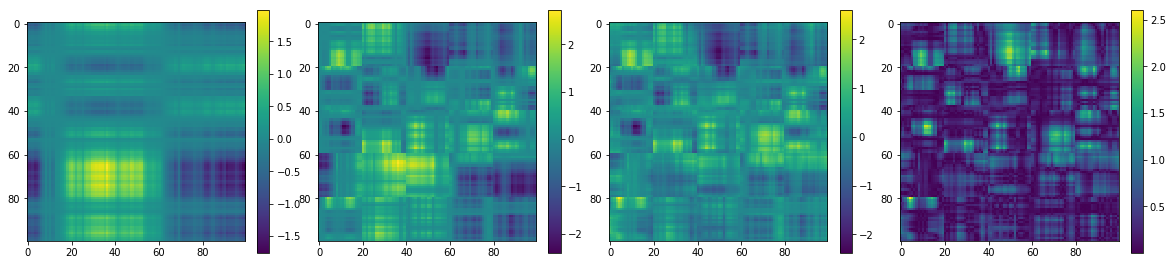

52.861702510584955
77.25262412192644
59.028648278991064


In [368]:
matrix = gaussianRandomSpatialField()
matrixGrid = matrixToGrid(matrix, 20, 20)
gridElementsReduced = []
for gridElement in matrixGrid:
    gridElementsReduced.append(reduceMatrix(gridElement, 1))
matrixReconstructed = gridToMatrix(numpy.array(gridElementsReduced))
matrixReduced = reduceMatrix(matrix, 1)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(matrixReconstructed)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(matrixReconstructed - matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(matrixReconstructed - matrixReduced))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(matrixReduced))
print(scipy.linalg.norm(matrixReconstructed))
print(scipy.linalg.norm(matrixReconstructed - matrixReduced))

Text

In [369]:
loop(testSVDByGrid)

1.1455518525494983

In [370]:
loop(testSVDByGrid, {"size": 100})

0.9427012203488888

In [371]:
loop(testSVDByGrid, {"size": 400})

1.311805198821941

In [372]:
loop(testSVDByGrid, {"nrows": 10, "ncols": 10})

1.2414228308476554

In [373]:
loop(testSVDByGrid, {"nrows": 40, "ncols": 40})

1.0039649790642422

In [374]:
loop(testSVDByGrid, {"alpha": 1})

2.3271218019553728

In [375]:
loop(testSVDByGrid, {"alpha": 4})

0.3827536189385938

In [376]:
loop(testSVDByGrid, {"p": 1})

1.4669093535963509

In [377]:
loop(testSVDByGrid, {"p": 4})

0.9009387219658876

#### Product of Spatio-Temporal Fields via Single Grid

Text

In [378]:
def matrixToGrid3D(array, gridSize):
    h, w, d = array.shape
    if h % gridSize > 0 or w % gridSize > 0:
        print("Shape does not fit")
        return []
    return array.reshape(h//gridSize, gridSize, -1, gridSize, d).swapaxes(1, 2).reshape(-1, gridSize, gridSize, d)

Text

In [379]:
def gridToMatrix3D(gridElements):
    widthSquared, nrows, ncols, d = gridElements.shape
    width = math.sqrt(widthSquared)
    if width % 1 > 0:
        print("Shape does not fit")
        return []
    width = int(width)
    return gridElements.swapaxes(0, 1).reshape(nrows, -1, width * ncols, d).swapaxes(0, 1).reshape(width * nrows, width * ncols, d)

Text

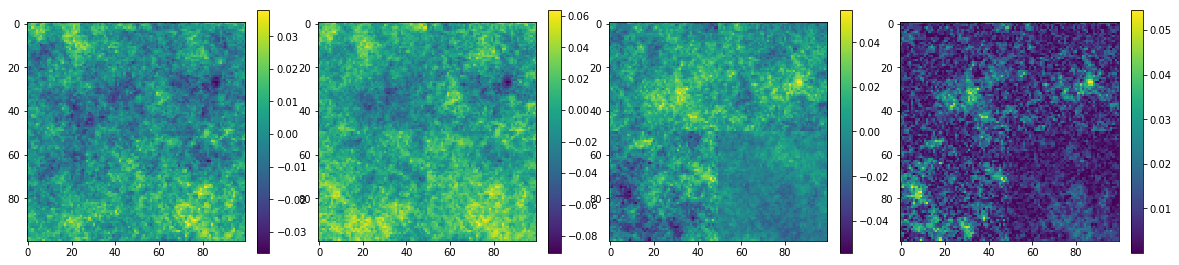

1.0
1.9999999999999998
1.3660398482875875


In [380]:
spatialSize=100
temporalSize=60
alpha=2
gridSize=50
number=0
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixSplit1, matrixSplit2 = splitSpatialTemporalField(matrixCombined)
matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixSplit1, matrixSplit2)
U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
UReshaped = U.reshape(spatialSize, spatialSize, temporalSize)
UReshapedExpectedGrid = matrixToGrid3D(UReshaped, gridSize)
matrixGrid1 = matrixToGrid3D(matrixSplit1, gridSize)
matrixGrid2 = matrixToGrid3D(matrixSplit2, gridSize)
gridElementsU = []
for i in range(len(matrixGrid1)):
    matrixFlattenedGrid1, matrixFlattenedGrid2 = flattenSpatialTemporalFields(matrixGrid1[i], matrixGrid2[i])
    UGrid, sGrid, VtGrid = qrProductSVD(matrixFlattenedGrid1, matrixFlattenedGrid2)
    UGridReshaped = UGrid.reshape(gridSize, gridSize, temporalSize)
    sign = []
    for j in range(temporalSize):
        if scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] - UGridReshaped[:, :, j]) > scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] + UGridReshaped[:, :, j]):
            sign.append(-1)
        else:
            sign.append(1)
    gridElementsU.append(UGridReshaped @ numpy.diag(sign))
UReshaped2 = gridToMatrix3D(numpy.array(gridElementsU))
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(UReshaped[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(UReshaped2[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(UReshaped[:, :, number] - UReshaped2[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(UReshaped[:, :, number] - UReshaped2[:, :, number]))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(UReshaped[:, :, number]))
print(scipy.linalg.norm(UReshaped2[:, :, number]))
print(scipy.linalg.norm(UReshaped2[:, :, number] - UReshaped[:, :, number]))

Text

In [381]:
def testProductSVDByGrid(spatialSize=100, temporalSize=60, alpha=2, gridSize=20):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixSplit1, matrixSplit2 = splitSpatialTemporalField(matrixCombined)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixSplit1, matrixSplit2)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    matrixGrid1 = matrixToGrid3D(matrixSplit1, gridSize)
    matrixGrid2 = matrixToGrid3D(matrixSplit2, gridSize)
    gridElementsU = []
    gridElementsV = []
    for i in range(len(matrixGrid1)):
        matrixFlattenedGrid1, matrixFlattenedGrid2 = flattenSpatialTemporalFields(matrixGrid1[i], matrixGrid2[i])
        UGrid, sGrid, VtGrid = qrProductSVD(matrixFlattenedGrid1, matrixFlattenedGrid2)
        gridElementsU.append(UGrid.reshape(gridSize, gridSize, temporalSize))
        gridElementsV.append(VtGrid.T.reshape(gridSize, gridSize, temporalSize))
    UReshaped2 = numpy.array(gridToMatrix3D(numpy.array(gridElementsU))).reshape(spatialSize * spatialSize, temporalSize)
    U2 = sklearn.preprocessing.normalize(UReshaped2, axis=0)
    VReshaped2 = numpy.array(gridToMatrix3D(numpy.array(gridElementsV))).reshape(spatialSize * spatialSize, temporalSize)
    V2 = sklearn.preprocessing.normalize(VReshaped2, axis=0)
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s, V2.T)

Text

In [382]:
loop(testProductSVDByGrid)

1.3862489443839365

In [383]:
loop(testProductSVDByGrid, {"temporalSize": 20})

1.3853182753355875

In [384]:
loop(testProductSVDByGrid, {"temporalSize": 100})

1.3824574462857344

In [385]:
loop(testProductSVDByGrid, {"gridSize": 10})

1.40664045198755

In [386]:
loop(testProductSVDByGrid, {"gridSize": 50})

1.2280301890394842

In [387]:
loop(testProductSVDByGrid, {"alpha": 1})

1.3861762394020147

In [388]:
loop(testProductSVDByGrid, {"alpha": 4})

1.3307570422878985

### Efficient SVD via Moving Grid Analysis

Text

#### Single Spatial Field via Moving Grid

Text

In [389]:
def matrixToFourGrids(dataArray, gridSize):
    halfGridSize = gridSize // 2
    arrayHeight, arrayWidth = dataArray.shape
    if (arrayHeight - halfGridSize) % halfGridSize > 0 or (arrayWidth - halfGridSize) % halfGridSize > 0:
        print("Shape does not fit")
        return []
    subArrays = [
        dataArray[:-halfGridSize, :-halfGridSize],
        dataArray[:-halfGridSize, halfGridSize:],
        dataArray[halfGridSize:, :-halfGridSize],
        dataArray[halfGridSize:, halfGridSize:]
    ]
    result = []
    for subArray in subArrays:
        result.append(matrixToGrid(subArray, gridSize, gridSize))
    return result

Text

In [390]:
def fourGridsToMatrix(subArrays):
    gridHeight, gridWidth = subArrays[0][0].shape
    halfGridHeight = gridHeight // 2
    halfGridWidth = gridWidth // 2
    matrices = []
    for subArray in subArrays:
        matrices.append(gridToMatrix(subArray))
    meanUpper = (matrices[0][:, halfGridWidth:] + matrices[1][:, :-halfGridWidth]) / 2
    concatenatedUpper = numpy.concatenate((matrices[0][:, :halfGridWidth], meanUpper, matrices[1][:, -halfGridWidth:]), axis=1)
    meanLower = (matrices[2][:, halfGridWidth:] + matrices[3][:, :-halfGridWidth]) / 2
    concatenatedLower = numpy.concatenate((matrices[2][:, :halfGridWidth], meanLower, matrices[3][:, -halfGridWidth:]), axis=1)
    mean = (concatenatedUpper[halfGridHeight:, :] + concatenatedLower[:-halfGridHeight, :]) / 2
    result = numpy.concatenate((concatenatedUpper[:halfGridHeight, :], mean, concatenatedLower[-halfGridHeight:, :]), axis=0)
    return result

Text

In [391]:
def testSVDByFourGrids(size=200, alpha=2, gridSize=20, p=2):
    size = size - size % gridSize + gridSize // 2
    matrix = gaussianRandomSpatialField(alpha, size)
    matrixFourGrids = matrixToFourGrids(matrix, gridSize)
    subArrays = []
    for matrixGrid in matrixFourGrids:
        gridElementsReduced = []
        for gridElement in matrixGrid:
            gridElementsReduced.append(reduceMatrix(gridElement, p))
        subArrays.append(numpy.array(gridElementsReduced))
    matrixReconstructed = fourGridsToMatrix(subArrays)
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(matrixReconstructed - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

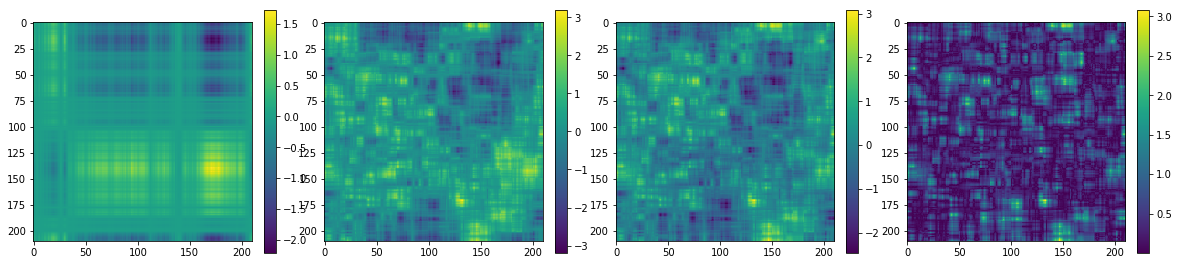

90.67274332500737
158.28090350834378
132.53746717103922


In [392]:
matrix = gaussianRandomSpatialField(size=210)
matrixFourGrids = matrixToFourGrids(matrix, 20)
subArrays = []
for matrixGrid in matrixFourGrids:
    gridElementsReduced = []
    for gridElement in matrixGrid:
        gridElementsReduced.append(reduceMatrix(gridElement, 1))
    subArrays.append(numpy.array(gridElementsReduced))
matrixReconstructed = fourGridsToMatrix(subArrays)
matrixReduced = reduceMatrix(matrix, 1)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(matrixReconstructed)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(matrixReconstructed - matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(matrixReconstructed - matrixReduced))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(matrixReduced))
print(scipy.linalg.norm(matrixReconstructed))
print(scipy.linalg.norm(matrixReconstructed - matrixReduced))

Text

In [393]:
loop(testSVDByFourGrids)

1.120628961717626

In [394]:
loop(testSVDByFourGrids, {"size": 100})

0.9297582639256354

In [395]:
loop(testSVDByFourGrids, {"size": 400})

1.2210230766885601

In [396]:
loop(testSVDByFourGrids, {"gridSize": 12})

1.194564193779299

In [397]:
loop(testSVDByFourGrids, {"gridSize": 40})

0.8916146429938034

In [398]:
loop(testSVDByFourGrids, {"alpha": 1})

2.0377093802333137

In [399]:
loop(testSVDByFourGrids, {"alpha": 4})

0.3672640589247644

In [400]:
loop(testSVDByFourGrids, {"p": 1})

1.4139749656668732

In [401]:
loop(testSVDByFourGrids, {"p": 4})

0.8627979516828207

## Bibliography

[1] T. P. Barnett and R. Preisendorfer. 1987. Origins and Levels of Monthly and Seasonal Forecast Skill for US surface Air Temperatures Determined by Canonical Correlation Analysis. Monthly Weather Review 115, 9 (1987), 1825–1850. https://doi.org/10.1175/1520-0493(1987)115<1825:OALOMA>2.0.CO;2

[2] Åke Björck and Gene H. Golub. 1973. Numerical Methods for Computing Angles Between Linear Subspaces. Math. Comp. 27, 123 (1973), 579–594.

[3] Laurens Bogaardt, Romulo Goncalves, Raul Zurita-Milla, and Emma Izquierdo-Verdiguier. 2018. Dataset Reduction Depending on Structure Scale. In Proceedings of SSDBM Conference (SSDBM). https://doi.org/xxx

[4] Christopher S. Bretherton, Catherine Smith, and John M. Wallace. 1992. An Inter-comparison of Methods for Finding Coupled Patterns in Climate Data. Journal of Climate 5, 6 (1992), 541–560. https://doi.org/10.1175/1520-0442(1992)005<0541: AIOMFF>2.0.CO;2

[5] Tony F. Chan. 1982. An Improved Algorithm for Computing the SVD. ACM Trans. Math. Softw. (1982), 72–83. https://doi.org/10.1145/355984.355990

[6] Carl Eckart and Gale Young. 1936. The approximation of one matrix by another of lower rank. Psychometrika (1936), 211–218. https://doi.org/10.1007/BF02288367

[7] Gidon Eshel. 2011. Spatiotemporal Data Analysis. Princeton University Press.

[8] G. H. Golub and C. Reinsch. 1970. Singular Value Decomposition and Least Squares Solutions. Numer. Math. 14 (1970), 403–420. https://doi.org/10.1007/ BF02163027

[9] N. Halko, P. G. Martinsson, and J. A. Tropp. 2011. Finding Structure with Ran- domness: Probabilistic Algorithms for Constructing Approximate Matrix Decom- positions. SIAM Rev. 53, 2 (2011), 217–288. https://doi.org/10.1137/090771806

[10] L. J. Hubert, R. G. Golledge, and C. M. Costanzo. 1981. Generalized Procedures for Evaluating Spatial Autocorrelation. Geographical Analysis 13, 3 (1981), 224–233. https://doi.org/10.1111/j.1538-4632.1981.tb00731.x

[11] Huamin Li, Yuval Kluger, and Mark Tygert. 2016. Randomized algorithms for distributed computation of principal component analysis and singular value decomposition. CoRR abs/1612.08709 (2016). http://arxiv.org/abs/1612.08709

[12] Per-Gunnar Martinsson. 2016. Randomized methods for matrix computations and analysis of high dimensional data. ArXiv (2016). https://arxiv.org/abs/1607.01649

[13] P. A. P. Moran. 1950. Notes on Continuous Stochastic Phenomena. Biometrika 37, 1/2 (1950), 17–23.

[14] Sergio Rey. 2009–2013. PySAL. http://pysal.readthedocs.io. (2009–2013).

[15] Mark Tygert. 2017. Suggested during personal communication. (18 10 2017).

[16] Hans von Storch and Francis W. Zwiers. 1999. Statistical Analysis In Climate Research. Cambridge University Press.

[17] Kobayashi, S., Ota, Y., Harada, Y., Ebita, A., Moriya, M., Onoda, H., … Takahashi, K. (2015). The JRA-55 Reanalysis: General Specifications and Basic Characteristics. Journal of the Meteorological Society of Japan. Ser. II, 93(1), 5–48. https://doi.org/10.2151/jmsj.2015-001

[18] Liu, Y., Attema, J., Moat, B., Hazeleger, W. (2018). Synthesis and Evaluation of Historical Meridional Heat Transport from Midlatitudes towards the Arctic. Climate Dynamics. Submitted.